In [17]:
%matplotlib inline

from math import exp, log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
def sigmoid(z):
    # print(z)
    try:
        return 1 / (1 + exp(-z))
    except OverflowError:
        return 0.0


In [3]:
def hw(X, w):
    return np.array(list(map(sigmoid, np.matmul(X, w))))
    # return np.array([sigmoid(x.dot(w)) for x in X])


In [4]:

def cost(h, y):
    # cost (hw(x), y) = − [y log(hw (x)) + (1 − y) log(1 − hw (x))]
    # return - (y * log(h) + (1-y) * log(1-h))
    if y == 0:
        if h == 1.0:
            h -= 1e-6
        return -log(1-h)
    else:
        if h == 0.0:
            h += 1e-6
        return -log(h)


def costs(hyp, y):
    return np.array([cost(h, target) for (h, target) in zip(hyp, y)])

In [5]:
# 2/6 - Only acts as regularized when a lambda is provided
def gradient_descent(X, y, nEpoch, alpha, lmbda=None):
    # w = np.random.uniform(size=(X.shape[1],))
    w = np.ones((X.shape[1],), dtype=np.float128)
    loss = -1
    for _ in np.arange(0, nEpoch):
        hypothesis = hw(X, w)
        loss = sum(costs(hypothesis, y))  # + sum(1/X.shape[0] * (w ** 2))

        error = hypothesis - y
        gradient = X.T.dot(error)

        if lmbda is None:
            w -= alpha * gradient
        else:
            w[0] -= alpha * gradient[0]
            w[1:] -= alpha * (gradient[1:] - lmbda * w[1:])

    print("epoch #{} alpha {} lambda {}, loss={:.7f}".format(nEpoch, alpha, lmbda, loss))

    return w

In [12]:
# h = [1, 0, 0, 0, 1]
# y = [1, 0, 0, 1, 0]
# 
# tp = list(map(all, zip(h, y))).count(True)
# tf = list(map(any, zip(h, y))).count(False)
# fp = list(zip(h, y)).count((1, 0))
# fn = list(zip(h, y)).count((0, 1))
# 
# print(tp, tf, fp, fn)


def accuracy(h, y):
    # Accuracy = TP + TN / TP +TN +FP +FN
    tp = list(map(all, zip(h, y))).count(True)
    tf = list(map(any, zip(h, y))).count(False)
    return (tp + tf) / h.shape[0]


def precision(h, y):
    # Precision = TP / (TP + FP)
    tp = list(map(all, zip(h, y))).count(True)
    fp = list(zip(h, y)).count((1, 0))
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)


def recall(h, y):
    # Recall = TP /(TP + FN)
    tp = list(map(all, zip(h, y))).count(True)
    fn = list(zip(h, y)).count((0, 1))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)


def f1(h, y):
    # F1 = 2 * (p * r / (p + r))
    p = precision(h, y)
    r = recall(h, y)
    if p+r == 0.0:
        return 0.0
    return 2 * (p * r / (p + r))


In [7]:
def kfold(k, X, y, epochs, alpha, lmbda=None):
    # K Fold cross validation

    # masks - just take every kth entry
    masks = []
    for i in range(k):
        mask = []
        for j in range(train_x.shape[0]):
            mask.append(j % k == i)
        masks.append(np.array(mask))

    total_a = 0
    total_p = 0
    total_r = 0
    total_f1 = 0
    for i, mask in enumerate(masks):
        test = X[mask]
        train = X[~mask]
        test_y = y[mask]
        train_y = y[~mask]

        w = gradient_descent(train, train_y, epochs, alpha, lmbda)
        h = hw(test, w)

        a = accuracy(h, test_y)
        p = precision(h, test_y)
        r = recall(h, test_y)
        f = f1(h, test_y)

        total_a += a
        total_p += p
        total_r += r
        total_f1 += f

        print(
            "{}-Fold CV, epochs {}, alpha {}, lambda {}, iteration {}: Acc: {:.7f}, Prec: {:.7f}, Rec: {:.7f}, F1: {:.7f}".format(
                k,
                epochs,
                alpha,
                lmbda,
                i, a,
                p, r,
                f))

    print(
        "{}-Fold CV, epochs {}, alpha {}, lambda {}, Average: Acc: {:.7f}, Prec: {:.7f}, Rec: {:.7f}, F1: {:.7f}".format(
            k, epochs,
            alpha,
            lmbda,
            total_a / k,
            total_p / k,
            total_r / k,
            total_f1 / k))
    return total_a / k, total_p / k, total_r / k, total_f1 / k


In [8]:
# Data Fetching and processing
train = pd.read_csv('bank-small-train.csv', sep=';')
test = pd.read_csv('bank-small-test.csv', sep=';')

factorizations = {}
for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(), test.iteritems()):
    if train_series.dtype == 'O':
        train[train_name], factorization = pd.factorize(train[train_name])
        test[test_name] = factorization.get_indexer(test[test_name])
        factorizations[train_name] = factorization

if factorizations['y'][0] == 'yes':
    # Make no 0 and yes 1 for sake of consistency
    train.iloc[:, -1] -= 1
    train.iloc[:, -1] = abs(train.iloc[:, -1])

# Data/Label splitting
train_x = train.iloc[:, :-1]
train_x_mmsc = train.iloc[:, :-1]
train_x_stdsc = train.iloc[:, :-1]
train_y = train.iloc[:, -1]
# train_y = train_y.values

test_x = test.iloc[:, :-1]
test_x_mmsc = test.iloc[:, :-1]
test_x_stdsc = test.iloc[:, :-1]
test_y = test.iloc[:, -1]
# test_y = test_y.values

# Add X0=1 to unscaled datasets
train_x.insert(0, 'X0', 1)
test_x.insert(0, 'X0', 1)
# train_x = train_x.values
# test_x = test_x.values

# Do Min Max Scaling and X0 addition
sc = MinMaxScaler()
sc.fit(train_x_mmsc)
train_x_mmsc = pd.DataFrame(sc.transform(train_x_mmsc), columns=train_x_mmsc.columns)
test_x_mmsc = pd.DataFrame(sc.transform(test_x_mmsc), columns=test_x_mmsc.columns)

train_x_mmsc.insert(0, 'X0', 1)
test_x_mmsc.insert(0, 'X0', 1)
# train_x_mmsc = train_x_mmsc.values
# test_x_mmsc = test_x_mmsc.values

# Standard Scaling and X0 addition
sc = StandardScaler()
sc.fit(train_x_stdsc)
train_x_stdsc = pd.DataFrame(sc.transform(train_x_stdsc), columns=train_x_stdsc.columns)
test_x_stdsc = pd.DataFrame(sc.transform(test_x_stdsc), columns=test_x_stdsc.columns)

train_x_stdsc.insert(0, 'X0', 1)
test_x_stdsc.insert(0, 'X0', 1)
# train_x_stdsc = train_x_stdsc.values
# test_x_stdsc = test_x_stdsc.values


epoch #100 alpha 0.01 lambda 0, loss=3939.2983656
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2282.7432810
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=10383.6882378
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5752.9622629
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=4906.3196129
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2712.2372099
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2149.0524751
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=1336.3113149
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5379.2247683
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2726.2571227
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3354.6179721
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1772.4741252
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2748.6693797
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1824.3752017
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1812.4975456
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3093.3578384
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1667.4705127
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2656.6572630
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=4398.0809355
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1472.1193926
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 10, loss=7617.8592820
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 0: Acc: 0.8585132, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #100 alpha 0.01 lambda 10, loss=10199.4385295
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 1: Acc: 0.8681055, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #100 alpha 0.01 lambda 10, loss=8798.7093027
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 2: Acc: 0.8752998, Prec: 0.5000000, Rec: 0.3600000, F1: 0.4186047


epoch #100 alpha 0.01 lambda 10, loss=9009.9705628
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5757576, Rec: 0.3800000, F1: 0.4578313


epoch #100 alpha 0.01 lambda 10, loss=7908.6363635
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 4: Acc: 0.8752998, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #100 alpha 0.01 lambda 10, loss=9221.7792898
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 5: Acc: 0.8537170, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #100 alpha 0.01 lambda 10, loss=7018.2091707
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 6: Acc: 0.8776978, Prec: 0.5116279, Rec: 0.4400000, F1: 0.4731183


epoch #100 alpha 0.01 lambda 10, loss=7719.9334328
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 7: Acc: 0.8365385, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 10, loss=7509.2431811
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 8: Acc: 0.8581731, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #100 alpha 0.01 lambda 10, loss=8699.4038937
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 9: Acc: 0.8846154, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 100, alpha 0.01, lambda 10, Average: Acc: 0.8675250, Prec: 0.4611106, Rec: 0.3540000, F1: 0.3988744


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #100 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #100 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #100 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #100 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #100 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #100 alpha 0.1 lambda 0, loss=73673.7393980
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=25598.8914896
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #100 alpha 0.1 lambda 0, loss=17510.0139115
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6097561, Rec: 1.0000000, F1: 0.7575758


epoch #100 alpha 0.1 lambda 0, loss=70021.9656154
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #100 alpha 0.1 lambda 0, loss=104663.2803255
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8258.6423239
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8996.3328303
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=45225.7846616
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9433962, Rec: 1.0000000, F1: 0.9708738


epoch #100 alpha 0.1 lambda 0, loss=118899.5881205
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=12986.4421640
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9321142, Rec: 1.0000000, F1: 0.9601699


epoch #100 alpha 0.1 lambda 1, loss=6641.0394204
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #100 alpha 0.1 lambda 1, loss=6272.2417933
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6341.3193461
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #100 alpha 0.1 lambda 1, loss=6775.7021492
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #100 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 6: Acc: 0.8824940, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6498.3664929
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #100 alpha 0.1 lambda 1, loss=6852.3952681
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 8: Acc: 0.8774038, Prec: 0.4814815, Rec: 0.2600000, F1: 0.3376623


epoch #100 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 100, alpha 0.1, lambda 1, Average: Acc: 0.8783256, Prec: 0.4923899, Rec: 0.2820000, F1: 0.3561888


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #100 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #100 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #100 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #100 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #100 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #100 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #100 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #100 alpha 1.0 lambda 0, loss=18783.3357928
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 0: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #100 alpha 1.0 lambda 0, loss=23406.2434589
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 0, loss=41402.6623154
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 2: Acc: 0.3908873, Prec: 0.8448276, Rec: 0.9800000, F1: 0.9074074


epoch #100 alpha 1.0 lambda 0, loss=21078.7256703
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 3: Acc: 0.7577938, Prec: 0.9069767, Rec: 0.7800000, F1: 0.8387097


epoch #100 alpha 1.0 lambda 0, loss=87100.1956959
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 4: Acc: 0.1582734, Prec: 0.5747126, Rec: 1.0000000, F1: 0.7299270


epoch #100 alpha 1.0 lambda 0, loss=63438.3971933
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 5: Acc: 0.1247002, Prec: 0.4032258, Rec: 1.0000000, F1: 0.5747126


epoch #100 alpha 1.0 lambda 0, loss=69473.8397003
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 6: Acc: 0.2182254, Prec: 0.6756757, Rec: 1.0000000, F1: 0.8064516


epoch #100 alpha 1.0 lambda 0, loss=23489.3591842
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 7: Acc: 0.7860577, Prec: 0.9000000, Rec: 0.7200000, F1: 0.8000000


epoch #100 alpha 1.0 lambda 0, loss=85231.8681344
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.5681818, Rec: 1.0000000, F1: 0.7246377


epoch #100 alpha 1.0 lambda 0, loss=24998.6157224
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 9: Acc: 0.8918269, Prec: 0.9615385, Rec: 0.5000000, F1: 0.6578947
10-Fold CV, epochs 100, alpha 1.0, lambda 0, Average: Acc: 0.5217758, Prec: 0.6835139, Rec: 0.7000000, F1: 0.6078956


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #100 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #100 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #100 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #500 alpha 0.01 lambda 0, loss=8508.5612425
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1754.9016726
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1273.6099052
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=5331.0801435
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1597.7332293
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=2512.7941219
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1307.8367315
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1680.3883038
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1967.6249793
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1488.4241419
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 1, loss=11577.6031050
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909


epoch #500 alpha 0.01 lambda 1, loss=10802.7929837
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=11240.4476740
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #500 alpha 0.01 lambda 1, loss=11093.5773813
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=10476.1602905
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10247.9008300
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 0.8928571, Rec: 1.0000000, F1: 0.9433962


epoch #500 alpha 0.01 lambda 1, loss=10689.1242223
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.01 lambda 1, loss=11124.8957915
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=9968.7789466
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10664.3764334
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909
10-Fold CV, epochs 500, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 0.8400394, Rec: 1.0000000, F1: 0.9127640


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #500 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #500 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #500 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #500 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #500 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 500, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #500 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #500 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #500 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #500 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #500 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #500 alpha 0.1 lambda 0, loss=86990.7452400
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=93573.9051137
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=33107.2318893
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.1 lambda 0, loss=7422.0948380
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9259259, Rec: 1.0000000, F1: 0.9615385


epoch #500 alpha 0.1 lambda 0, loss=27447.8127013
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8620690, Rec: 1.0000000, F1: 0.9259259


epoch #500 alpha 0.1 lambda 0, loss=9716.4616731
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 0.7142857, Rec: 1.0000000, F1: 0.8333333


epoch #500 alpha 0.1 lambda 0, loss=11823.1367638
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=60676.3249639
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #500 alpha 0.1 lambda 0, loss=50070.1172840
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=11047.1599968
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9311277, Rec: 1.0000000, F1: 0.9618621


epoch #500 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #500 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #500 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 500, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #500 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #500 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #500 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #500 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #500 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #500 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #500 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #500 alpha 1.0 lambda 0, loss=19201.1367774
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 0: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0400000, F1: 0.0769231


epoch #500 alpha 1.0 lambda 0, loss=19211.0958978
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 1: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0600000, F1: 0.1132075


epoch #500 alpha 1.0 lambda 0, loss=11292.5278667
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 2: Acc: 0.8752998, Prec: 0.9333333, Rec: 0.2800000, F1: 0.4307692


epoch #500 alpha 1.0 lambda 0, loss=18576.7224342
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 3: Acc: 0.8776978, Prec: 0.6666667, Rec: 0.0400000, F1: 0.0754717


epoch #500 alpha 1.0 lambda 0, loss=79375.6452278
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.3267974, Rec: 1.0000000, F1: 0.4926108


epoch #500 alpha 1.0 lambda 0, loss=26739.8066905
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 5: Acc: 0.6882494, Prec: 0.9583333, Rec: 0.9200000, F1: 0.9387755


epoch #500 alpha 1.0 lambda 0, loss=32088.2021766
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 6: Acc: 0.4508393, Prec: 0.8909091, Rec: 0.9800000, F1: 0.9333333


epoch #500 alpha 1.0 lambda 0, loss=28270.0977080
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 7: Acc: 0.6105769, Prec: 0.8775510, Rec: 0.8600000, F1: 0.8686869


epoch #500 alpha 1.0 lambda 0, loss=121948.2503983
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.3355705, Rec: 1.0000000, F1: 0.5025126


epoch #500 alpha 1.0 lambda 0, loss=20867.1582046
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 9: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157
10-Fold CV, epochs 500, alpha 1.0, lambda 0, Average: Acc: 0.6401967, Prec: 0.7989161, Rec: 0.5200000, F1: 0.4471506


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #500 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #500 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #500 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #1000 alpha 0.01 lambda 0, loss=5443.4897022
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2558.4210729
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2252.4449404
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2210.1472390
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2265.7785245
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=7209.8156532
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=3645.0147987
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1788.9913965
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1309.3315244
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=4191.7853994
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 1, loss=14440.3256067
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 0: Acc: 0.8441247, Prec: 0.4590164, Rec: 0.5600000, F1: 0.5045045


epoch #1000 alpha 0.01 lambda 1, loss=12388.0817718
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 1: Acc: 0.8513189, Prec: 0.4871795, Rec: 0.7600000, F1: 0.5937500


epoch #1000 alpha 0.01 lambda 1, loss=15615.5111504
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 2: Acc: 0.8417266, Prec: 0.4189189, Rec: 0.6200000, F1: 0.5000000


epoch #1000 alpha 0.01 lambda 1, loss=16752.6803894
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 3: Acc: 0.8393285, Prec: 0.4179104, Rec: 0.5600000, F1: 0.4786325


epoch #1000 alpha 0.01 lambda 1, loss=14313.3815366
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 4: Acc: 0.8561151, Prec: 0.4857143, Rec: 0.6800000, F1: 0.5666667


epoch #1000 alpha 0.01 lambda 1, loss=16934.4575379
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 5: Acc: 0.8393285, Prec: 0.4473684, Rec: 0.6800000, F1: 0.5396825


epoch #1000 alpha 0.01 lambda 1, loss=16943.7796634
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 6: Acc: 0.8657074, Prec: 0.5072464, Rec: 0.7000000, F1: 0.5882353


epoch #1000 alpha 0.01 lambda 1, loss=17714.7330643
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 7: Acc: 0.8365385, Prec: 0.3934426, Rec: 0.4800000, F1: 0.4324324


epoch #1000 alpha 0.01 lambda 1, loss=18035.0510683
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 8: Acc: 0.8461538, Prec: 0.4647887, Rec: 0.6600000, F1: 0.5454545


epoch #1000 alpha 0.01 lambda 1, loss=17153.3229135
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 9: Acc: 0.8701923, Prec: 0.5138889, Rec: 0.7400000, F1: 0.6065574
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, Average: Acc: 0.8490534, Prec: 0.4595475, Rec: 0.6440000, F1: 0.5355916


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #1000 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #1000 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #1000 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #1000 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #1000 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #1000 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #1000 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #1000 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #1000 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #1000 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #1000 alpha 0.1 lambda 0, loss=18247.5987882
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=26698.4495791
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=13853.4633106
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6024096, Rec: 1.0000000, F1: 0.7518797


epoch #1000 alpha 0.1 lambda 0, loss=20060.1255948
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.7462687, Rec: 1.0000000, F1: 0.8547009


epoch #1000 alpha 0.1 lambda 0, loss=9987.5222644
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #1000 alpha 0.1 lambda 0, loss=19175.8970088
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=8157.9375344
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=17949.2187878
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=16604.6200426
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=15718.0681116
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9168350, Rec: 1.0000000, F1: 0.9507481


epoch #1000 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #1000 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #1000 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #1000 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #1000 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #1000 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #1000 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #1000 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #1000 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #1000 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #1000 alpha 1.0 lambda 0, loss=93433.3632046
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 0: Acc: 0.1342926, Prec: 0.4000000, Rec: 1.0000000, F1: 0.5714286


epoch #1000 alpha 1.0 lambda 0, loss=21415.5763262
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 1: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=87430.1660504
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 2: Acc: 0.1223022, Prec: 0.3144654, Rec: 1.0000000, F1: 0.4784689


epoch #1000 alpha 1.0 lambda 0, loss=8882.2512777
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 3: Acc: 0.8896882, Prec: 0.8461538, Rec: 0.2200000, F1: 0.3492063


epoch #1000 alpha 1.0 lambda 0, loss=42288.4305768
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 4: Acc: 0.3477218, Prec: 0.8596491, Rec: 0.9800000, F1: 0.9158879


epoch #1000 alpha 1.0 lambda 0, loss=7753.8724923
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 5: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.1200000, F1: 0.2142857


epoch #1000 alpha 1.0 lambda 0, loss=86449.8231435
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 6: Acc: 0.1462830, Prec: 0.6172840, Rec: 1.0000000, F1: 0.7633588


epoch #1000 alpha 1.0 lambda 0, loss=20412.0376714
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 7: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=22062.5989061
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 0, loss=8456.9705561
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 9: Acc: 0.8942308, Prec: 1.0000000, Rec: 0.2800000, F1: 0.4375000
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, Average: Acc: 0.6061526, Prec: 0.7037552, Rec: 0.4640000, F1: 0.3808568


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #1000 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #1000 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #1000 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #100 alpha 0.01 lambda 0, loss=1495.2937153
7b - epochs 100, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #100 alpha 0.01 lambda 1, loss=2559.0687790
7b - epochs 100, alpha 0.01, lambda 1: Acc: 0.8792897, Prec: 0.8799232, Rec: 0.9991819, F1: 0.9357681


epoch #100 alpha 0.01 lambda 10, loss=9394.8855126
7b - epochs 100, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #100 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #100 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 100, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #100 alpha 0.1 lambda 0, loss=10154.3125487
7b - epochs 100, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #100 alpha 0.1 lambda 1, loss=6949.2018107
7b - epochs 100, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #100 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #100 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 100, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #100 alpha 1.0 lambda 0, loss=8422.7557344
7b - epochs 100, alpha 1.0, lambda 0: Acc: 0.8780898, Prec: 0.8797788, Rec: 0.9978184, F1: 0.9350882


epoch #100 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #100 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #100 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 100, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #500 alpha 0.01 lambda 0, loss=5369.7320792
7b - epochs 500, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #500 alpha 0.01 lambda 1, loss=11836.7773718
7b - epochs 500, alpha 0.01, lambda 1: Acc: 0.8773698, Prec: 0.8796920, Rec: 0.9970003, F1: 0.9346798


epoch #500 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 500, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #500 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #500 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 500, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #500 alpha 0.1 lambda 0, loss=7991.6880966
7b - epochs 500, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #500 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #500 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #500 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 500, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #500 alpha 1.0 lambda 0, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 0: Acc: 0.8725702, Prec: 0.8791103, Rec: 0.9915462, F1: 0.9319493


epoch #500 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #500 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #500 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 500, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #1000 alpha 0.01 lambda 0, loss=1528.6379771
7b - epochs 1000, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #1000 alpha 0.01 lambda 1, loss=21033.6155341
7b - epochs 1000, alpha 0.01, lambda 1: Acc: 0.8771298, Prec: 0.8796631, Rec: 0.9967276, F1: 0.9345436


epoch #1000 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 1000, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #1000 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #1000 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 1000, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #1000 alpha 0.1 lambda 0, loss=8337.3004182
7b - epochs 1000, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #1000 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #1000 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 1000, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #1000 alpha 1.0 lambda 0, loss=32132.2610842
7b - epochs 1000, alpha 1.0, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #1000 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #1000 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 1000, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


In [9]:
# Run settings
epochs = [100, 500, 1000]
alphas = [0.01, 0.1, 1.0]

results = []

epoch #100 alpha 0.01 lambda 0, loss=3939.2983656
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2282.7432810
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=10383.6882378
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5752.9622629
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=4906.3196129
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2712.2372099
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2149.0524751
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=1336.3113149
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5379.2247683
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2726.2571227
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3354.6179721
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1772.4741252
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2748.6693797
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1824.3752017
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1812.4975456
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3093.3578384
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1667.4705127
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2656.6572630
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=4398.0809355
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1472.1193926
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 10, loss=7617.8592820
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 0: Acc: 0.8585132, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #100 alpha 0.01 lambda 10, loss=10199.4385295
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 1: Acc: 0.8681055, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #100 alpha 0.01 lambda 10, loss=8798.7093027
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 2: Acc: 0.8752998, Prec: 0.5000000, Rec: 0.3600000, F1: 0.4186047


epoch #100 alpha 0.01 lambda 10, loss=9009.9705628
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5757576, Rec: 0.3800000, F1: 0.4578313


epoch #100 alpha 0.01 lambda 10, loss=7908.6363635
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 4: Acc: 0.8752998, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #100 alpha 0.01 lambda 10, loss=9221.7792898
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 5: Acc: 0.8537170, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #100 alpha 0.01 lambda 10, loss=7018.2091707
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 6: Acc: 0.8776978, Prec: 0.5116279, Rec: 0.4400000, F1: 0.4731183


epoch #100 alpha 0.01 lambda 10, loss=7719.9334328
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 7: Acc: 0.8365385, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 10, loss=7509.2431811
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 8: Acc: 0.8581731, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #100 alpha 0.01 lambda 10, loss=8699.4038937
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 9: Acc: 0.8846154, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 100, alpha 0.01, lambda 10, Average: Acc: 0.8675250, Prec: 0.4611106, Rec: 0.3540000, F1: 0.3988744


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #100 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #100 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #100 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #100 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #100 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #100 alpha 0.1 lambda 0, loss=73673.7393980
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=25598.8914896
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #100 alpha 0.1 lambda 0, loss=17510.0139115
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6097561, Rec: 1.0000000, F1: 0.7575758


epoch #100 alpha 0.1 lambda 0, loss=70021.9656154
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #100 alpha 0.1 lambda 0, loss=104663.2803255
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8258.6423239
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8996.3328303
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=45225.7846616
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9433962, Rec: 1.0000000, F1: 0.9708738


epoch #100 alpha 0.1 lambda 0, loss=118899.5881205
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=12986.4421640
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9321142, Rec: 1.0000000, F1: 0.9601699


epoch #100 alpha 0.1 lambda 1, loss=6641.0394204
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #100 alpha 0.1 lambda 1, loss=6272.2417933
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6341.3193461
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #100 alpha 0.1 lambda 1, loss=6775.7021492
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #100 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 6: Acc: 0.8824940, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6498.3664929
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #100 alpha 0.1 lambda 1, loss=6852.3952681
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 8: Acc: 0.8774038, Prec: 0.4814815, Rec: 0.2600000, F1: 0.3376623


epoch #100 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 100, alpha 0.1, lambda 1, Average: Acc: 0.8783256, Prec: 0.4923899, Rec: 0.2820000, F1: 0.3561888


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #100 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #100 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #100 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #100 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #100 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #100 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #100 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #100 alpha 1.0 lambda 0, loss=18783.3357928
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 0: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #100 alpha 1.0 lambda 0, loss=23406.2434589
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 0, loss=41402.6623154
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 2: Acc: 0.3908873, Prec: 0.8448276, Rec: 0.9800000, F1: 0.9074074


epoch #100 alpha 1.0 lambda 0, loss=21078.7256703
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 3: Acc: 0.7577938, Prec: 0.9069767, Rec: 0.7800000, F1: 0.8387097


epoch #100 alpha 1.0 lambda 0, loss=87100.1956959
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 4: Acc: 0.1582734, Prec: 0.5747126, Rec: 1.0000000, F1: 0.7299270


epoch #100 alpha 1.0 lambda 0, loss=63438.3971933
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 5: Acc: 0.1247002, Prec: 0.4032258, Rec: 1.0000000, F1: 0.5747126


epoch #100 alpha 1.0 lambda 0, loss=69473.8397003
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 6: Acc: 0.2182254, Prec: 0.6756757, Rec: 1.0000000, F1: 0.8064516


epoch #100 alpha 1.0 lambda 0, loss=23489.3591842
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 7: Acc: 0.7860577, Prec: 0.9000000, Rec: 0.7200000, F1: 0.8000000


epoch #100 alpha 1.0 lambda 0, loss=85231.8681344
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.5681818, Rec: 1.0000000, F1: 0.7246377


epoch #100 alpha 1.0 lambda 0, loss=24998.6157224
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 9: Acc: 0.8918269, Prec: 0.9615385, Rec: 0.5000000, F1: 0.6578947
10-Fold CV, epochs 100, alpha 1.0, lambda 0, Average: Acc: 0.5217758, Prec: 0.6835139, Rec: 0.7000000, F1: 0.6078956


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #100 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #100 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #100 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #500 alpha 0.01 lambda 0, loss=8508.5612425
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1754.9016726
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1273.6099052
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=5331.0801435
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1597.7332293
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=2512.7941219
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1307.8367315
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1680.3883038
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1967.6249793
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1488.4241419
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 1, loss=11577.6031050
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909


epoch #500 alpha 0.01 lambda 1, loss=10802.7929837
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=11240.4476740
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #500 alpha 0.01 lambda 1, loss=11093.5773813
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=10476.1602905
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10247.9008300
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 0.8928571, Rec: 1.0000000, F1: 0.9433962


epoch #500 alpha 0.01 lambda 1, loss=10689.1242223
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.01 lambda 1, loss=11124.8957915
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=9968.7789466
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10664.3764334
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909
10-Fold CV, epochs 500, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 0.8400394, Rec: 1.0000000, F1: 0.9127640


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #500 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #500 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #500 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #500 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #500 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 500, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #500 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #500 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #500 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #500 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #500 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #500 alpha 0.1 lambda 0, loss=86990.7452400
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=93573.9051137
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=33107.2318893
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.1 lambda 0, loss=7422.0948380
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9259259, Rec: 1.0000000, F1: 0.9615385


epoch #500 alpha 0.1 lambda 0, loss=27447.8127013
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8620690, Rec: 1.0000000, F1: 0.9259259


epoch #500 alpha 0.1 lambda 0, loss=9716.4616731
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 0.7142857, Rec: 1.0000000, F1: 0.8333333


epoch #500 alpha 0.1 lambda 0, loss=11823.1367638
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=60676.3249639
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #500 alpha 0.1 lambda 0, loss=50070.1172840
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=11047.1599968
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9311277, Rec: 1.0000000, F1: 0.9618621


epoch #500 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #500 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #500 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 500, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #500 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #500 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #500 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #500 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #500 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #500 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #500 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #500 alpha 1.0 lambda 0, loss=19201.1367774
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 0: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0400000, F1: 0.0769231


epoch #500 alpha 1.0 lambda 0, loss=19211.0958978
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 1: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0600000, F1: 0.1132075


epoch #500 alpha 1.0 lambda 0, loss=11292.5278667
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 2: Acc: 0.8752998, Prec: 0.9333333, Rec: 0.2800000, F1: 0.4307692


epoch #500 alpha 1.0 lambda 0, loss=18576.7224342
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 3: Acc: 0.8776978, Prec: 0.6666667, Rec: 0.0400000, F1: 0.0754717


epoch #500 alpha 1.0 lambda 0, loss=79375.6452278
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.3267974, Rec: 1.0000000, F1: 0.4926108


epoch #500 alpha 1.0 lambda 0, loss=26739.8066905
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 5: Acc: 0.6882494, Prec: 0.9583333, Rec: 0.9200000, F1: 0.9387755


epoch #500 alpha 1.0 lambda 0, loss=32088.2021766
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 6: Acc: 0.4508393, Prec: 0.8909091, Rec: 0.9800000, F1: 0.9333333


epoch #500 alpha 1.0 lambda 0, loss=28270.0977080
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 7: Acc: 0.6105769, Prec: 0.8775510, Rec: 0.8600000, F1: 0.8686869


epoch #500 alpha 1.0 lambda 0, loss=121948.2503983
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.3355705, Rec: 1.0000000, F1: 0.5025126


epoch #500 alpha 1.0 lambda 0, loss=20867.1582046
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 9: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157
10-Fold CV, epochs 500, alpha 1.0, lambda 0, Average: Acc: 0.6401967, Prec: 0.7989161, Rec: 0.5200000, F1: 0.4471506


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #500 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #500 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #500 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #1000 alpha 0.01 lambda 0, loss=5443.4897022
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2558.4210729
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2252.4449404
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2210.1472390
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2265.7785245
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=7209.8156532
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=3645.0147987
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1788.9913965
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1309.3315244
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=4191.7853994
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 1, loss=14440.3256067
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 0: Acc: 0.8441247, Prec: 0.4590164, Rec: 0.5600000, F1: 0.5045045


epoch #1000 alpha 0.01 lambda 1, loss=12388.0817718
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 1: Acc: 0.8513189, Prec: 0.4871795, Rec: 0.7600000, F1: 0.5937500


epoch #1000 alpha 0.01 lambda 1, loss=15615.5111504
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 2: Acc: 0.8417266, Prec: 0.4189189, Rec: 0.6200000, F1: 0.5000000


epoch #1000 alpha 0.01 lambda 1, loss=16752.6803894
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 3: Acc: 0.8393285, Prec: 0.4179104, Rec: 0.5600000, F1: 0.4786325


epoch #1000 alpha 0.01 lambda 1, loss=14313.3815366
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 4: Acc: 0.8561151, Prec: 0.4857143, Rec: 0.6800000, F1: 0.5666667


epoch #1000 alpha 0.01 lambda 1, loss=16934.4575379
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 5: Acc: 0.8393285, Prec: 0.4473684, Rec: 0.6800000, F1: 0.5396825


epoch #1000 alpha 0.01 lambda 1, loss=16943.7796634
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 6: Acc: 0.8657074, Prec: 0.5072464, Rec: 0.7000000, F1: 0.5882353


epoch #1000 alpha 0.01 lambda 1, loss=17714.7330643
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 7: Acc: 0.8365385, Prec: 0.3934426, Rec: 0.4800000, F1: 0.4324324


epoch #1000 alpha 0.01 lambda 1, loss=18035.0510683
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 8: Acc: 0.8461538, Prec: 0.4647887, Rec: 0.6600000, F1: 0.5454545


epoch #1000 alpha 0.01 lambda 1, loss=17153.3229135
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 9: Acc: 0.8701923, Prec: 0.5138889, Rec: 0.7400000, F1: 0.6065574
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, Average: Acc: 0.8490534, Prec: 0.4595475, Rec: 0.6440000, F1: 0.5355916


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #1000 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #1000 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #1000 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #1000 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #1000 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #1000 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #1000 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #1000 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #1000 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #1000 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #1000 alpha 0.1 lambda 0, loss=18247.5987882
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=26698.4495791
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=13853.4633106
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6024096, Rec: 1.0000000, F1: 0.7518797


epoch #1000 alpha 0.1 lambda 0, loss=20060.1255948
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.7462687, Rec: 1.0000000, F1: 0.8547009


epoch #1000 alpha 0.1 lambda 0, loss=9987.5222644
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #1000 alpha 0.1 lambda 0, loss=19175.8970088
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=8157.9375344
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=17949.2187878
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=16604.6200426
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=15718.0681116
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9168350, Rec: 1.0000000, F1: 0.9507481


epoch #1000 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #1000 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #1000 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #1000 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #1000 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #1000 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #1000 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #1000 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #1000 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #1000 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #1000 alpha 1.0 lambda 0, loss=93433.3632046
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 0: Acc: 0.1342926, Prec: 0.4000000, Rec: 1.0000000, F1: 0.5714286


epoch #1000 alpha 1.0 lambda 0, loss=21415.5763262
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 1: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=87430.1660504
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 2: Acc: 0.1223022, Prec: 0.3144654, Rec: 1.0000000, F1: 0.4784689


epoch #1000 alpha 1.0 lambda 0, loss=8882.2512777
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 3: Acc: 0.8896882, Prec: 0.8461538, Rec: 0.2200000, F1: 0.3492063


epoch #1000 alpha 1.0 lambda 0, loss=42288.4305768
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 4: Acc: 0.3477218, Prec: 0.8596491, Rec: 0.9800000, F1: 0.9158879


epoch #1000 alpha 1.0 lambda 0, loss=7753.8724923
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 5: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.1200000, F1: 0.2142857


epoch #1000 alpha 1.0 lambda 0, loss=86449.8231435
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 6: Acc: 0.1462830, Prec: 0.6172840, Rec: 1.0000000, F1: 0.7633588


epoch #1000 alpha 1.0 lambda 0, loss=20412.0376714
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 7: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=22062.5989061
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 0, loss=8456.9705561
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 9: Acc: 0.8942308, Prec: 1.0000000, Rec: 0.2800000, F1: 0.4375000
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, Average: Acc: 0.6061526, Prec: 0.7037552, Rec: 0.4640000, F1: 0.3808568


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #1000 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #1000 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #1000 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #100 alpha 0.01 lambda 0, loss=1495.2937153
7b - epochs 100, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #100 alpha 0.01 lambda 1, loss=2559.0687790
7b - epochs 100, alpha 0.01, lambda 1: Acc: 0.8792897, Prec: 0.8799232, Rec: 0.9991819, F1: 0.9357681


epoch #100 alpha 0.01 lambda 10, loss=9394.8855126
7b - epochs 100, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #100 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #100 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 100, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #100 alpha 0.1 lambda 0, loss=10154.3125487
7b - epochs 100, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #100 alpha 0.1 lambda 1, loss=6949.2018107
7b - epochs 100, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #100 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #100 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 100, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #100 alpha 1.0 lambda 0, loss=8422.7557344
7b - epochs 100, alpha 1.0, lambda 0: Acc: 0.8780898, Prec: 0.8797788, Rec: 0.9978184, F1: 0.9350882


epoch #100 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #100 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #100 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 100, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #500 alpha 0.01 lambda 0, loss=5369.7320792
7b - epochs 500, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #500 alpha 0.01 lambda 1, loss=11836.7773718
7b - epochs 500, alpha 0.01, lambda 1: Acc: 0.8773698, Prec: 0.8796920, Rec: 0.9970003, F1: 0.9346798


epoch #500 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 500, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #500 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #500 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 500, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #500 alpha 0.1 lambda 0, loss=7991.6880966
7b - epochs 500, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #500 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #500 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #500 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 500, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #500 alpha 1.0 lambda 0, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 0: Acc: 0.8725702, Prec: 0.8791103, Rec: 0.9915462, F1: 0.9319493


epoch #500 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #500 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #500 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 500, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #1000 alpha 0.01 lambda 0, loss=1528.6379771
7b - epochs 1000, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #1000 alpha 0.01 lambda 1, loss=21033.6155341
7b - epochs 1000, alpha 0.01, lambda 1: Acc: 0.8771298, Prec: 0.8796631, Rec: 0.9967276, F1: 0.9345436


epoch #1000 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 1000, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #1000 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #1000 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 1000, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #1000 alpha 0.1 lambda 0, loss=8337.3004182
7b - epochs 1000, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #1000 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #1000 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 1000, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #1000 alpha 1.0 lambda 0, loss=32132.2610842
7b - epochs 1000, alpha 1.0, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #1000 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #1000 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 1000, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


In [10]:
# 3a - 10 fold cross validation on the raw data
for epoch in epochs:
    for alpha in alphas:
        a, p, r, f = kfold(10, train_x, train_y, epoch, alpha)
        results.append(['3a epochs={} alpha={}'.format(epoch, alpha), a, p, r, f])

# 3b Full data set - raw
for epoch in epochs:
    for alpha in alphas:
        w = gradient_descent(train_x, train_y, epoch, alpha)
        h = hw(test_x, w)
        
        a = accuracy(h, test_y)
        p = precision(h, test_y)
        r = recall(h, test_y)
        f = f1(h, test_y)
        
        print(
            "3b - epochs {}, alpha {}: Acc: {:.7f}, Prec: {:.7f}, Rec: {:.7f}, F1: {:.7f}".format(epoch, alpha, a, p, r,
                                                                                                 f))
        results.append(["3b epochs={} alpha={}".format(epoch, alpha), a, p, r, f])


epoch #100 alpha 0.01 lambda 0, loss=3939.2983656
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2282.7432810
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=10383.6882378
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5752.9622629
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=4906.3196129
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2712.2372099
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2149.0524751
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=1336.3113149
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5379.2247683
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2726.2571227
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3354.6179721
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1772.4741252
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2748.6693797
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1824.3752017
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1812.4975456
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3093.3578384
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1667.4705127
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2656.6572630
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=4398.0809355
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1472.1193926
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 10, loss=7617.8592820
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 0: Acc: 0.8585132, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #100 alpha 0.01 lambda 10, loss=10199.4385295
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 1: Acc: 0.8681055, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #100 alpha 0.01 lambda 10, loss=8798.7093027
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 2: Acc: 0.8752998, Prec: 0.5000000, Rec: 0.3600000, F1: 0.4186047


epoch #100 alpha 0.01 lambda 10, loss=9009.9705628
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5757576, Rec: 0.3800000, F1: 0.4578313


epoch #100 alpha 0.01 lambda 10, loss=7908.6363635
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 4: Acc: 0.8752998, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #100 alpha 0.01 lambda 10, loss=9221.7792898
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 5: Acc: 0.8537170, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #100 alpha 0.01 lambda 10, loss=7018.2091707
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 6: Acc: 0.8776978, Prec: 0.5116279, Rec: 0.4400000, F1: 0.4731183


epoch #100 alpha 0.01 lambda 10, loss=7719.9334328
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 7: Acc: 0.8365385, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 10, loss=7509.2431811
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 8: Acc: 0.8581731, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #100 alpha 0.01 lambda 10, loss=8699.4038937
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 9: Acc: 0.8846154, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 100, alpha 0.01, lambda 10, Average: Acc: 0.8675250, Prec: 0.4611106, Rec: 0.3540000, F1: 0.3988744


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #100 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #100 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #100 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #100 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #100 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #100 alpha 0.1 lambda 0, loss=73673.7393980
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=25598.8914896
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #100 alpha 0.1 lambda 0, loss=17510.0139115
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6097561, Rec: 1.0000000, F1: 0.7575758


epoch #100 alpha 0.1 lambda 0, loss=70021.9656154
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #100 alpha 0.1 lambda 0, loss=104663.2803255
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8258.6423239
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8996.3328303
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=45225.7846616
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9433962, Rec: 1.0000000, F1: 0.9708738


epoch #100 alpha 0.1 lambda 0, loss=118899.5881205
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=12986.4421640
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9321142, Rec: 1.0000000, F1: 0.9601699


epoch #100 alpha 0.1 lambda 1, loss=6641.0394204
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #100 alpha 0.1 lambda 1, loss=6272.2417933
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6341.3193461
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #100 alpha 0.1 lambda 1, loss=6775.7021492
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #100 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 6: Acc: 0.8824940, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6498.3664929
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #100 alpha 0.1 lambda 1, loss=6852.3952681
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 8: Acc: 0.8774038, Prec: 0.4814815, Rec: 0.2600000, F1: 0.3376623


epoch #100 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 100, alpha 0.1, lambda 1, Average: Acc: 0.8783256, Prec: 0.4923899, Rec: 0.2820000, F1: 0.3561888


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #100 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #100 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #100 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #100 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #100 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #100 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #100 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #100 alpha 1.0 lambda 0, loss=18783.3357928
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 0: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #100 alpha 1.0 lambda 0, loss=23406.2434589
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 0, loss=41402.6623154
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 2: Acc: 0.3908873, Prec: 0.8448276, Rec: 0.9800000, F1: 0.9074074


epoch #100 alpha 1.0 lambda 0, loss=21078.7256703
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 3: Acc: 0.7577938, Prec: 0.9069767, Rec: 0.7800000, F1: 0.8387097


epoch #100 alpha 1.0 lambda 0, loss=87100.1956959
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 4: Acc: 0.1582734, Prec: 0.5747126, Rec: 1.0000000, F1: 0.7299270


epoch #100 alpha 1.0 lambda 0, loss=63438.3971933
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 5: Acc: 0.1247002, Prec: 0.4032258, Rec: 1.0000000, F1: 0.5747126


epoch #100 alpha 1.0 lambda 0, loss=69473.8397003
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 6: Acc: 0.2182254, Prec: 0.6756757, Rec: 1.0000000, F1: 0.8064516


epoch #100 alpha 1.0 lambda 0, loss=23489.3591842
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 7: Acc: 0.7860577, Prec: 0.9000000, Rec: 0.7200000, F1: 0.8000000


epoch #100 alpha 1.0 lambda 0, loss=85231.8681344
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.5681818, Rec: 1.0000000, F1: 0.7246377


epoch #100 alpha 1.0 lambda 0, loss=24998.6157224
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 9: Acc: 0.8918269, Prec: 0.9615385, Rec: 0.5000000, F1: 0.6578947
10-Fold CV, epochs 100, alpha 1.0, lambda 0, Average: Acc: 0.5217758, Prec: 0.6835139, Rec: 0.7000000, F1: 0.6078956


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #100 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #100 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #100 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #500 alpha 0.01 lambda 0, loss=8508.5612425
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1754.9016726
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1273.6099052
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=5331.0801435
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1597.7332293
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=2512.7941219
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1307.8367315
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1680.3883038
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1967.6249793
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1488.4241419
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 1, loss=11577.6031050
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909


epoch #500 alpha 0.01 lambda 1, loss=10802.7929837
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=11240.4476740
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #500 alpha 0.01 lambda 1, loss=11093.5773813
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=10476.1602905
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10247.9008300
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 0.8928571, Rec: 1.0000000, F1: 0.9433962


epoch #500 alpha 0.01 lambda 1, loss=10689.1242223
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.01 lambda 1, loss=11124.8957915
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=9968.7789466
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10664.3764334
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909
10-Fold CV, epochs 500, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 0.8400394, Rec: 1.0000000, F1: 0.9127640


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #500 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #500 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #500 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #500 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #500 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 500, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #500 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #500 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #500 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #500 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #500 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #500 alpha 0.1 lambda 0, loss=86990.7452400
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=93573.9051137
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=33107.2318893
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.1 lambda 0, loss=7422.0948380
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9259259, Rec: 1.0000000, F1: 0.9615385


epoch #500 alpha 0.1 lambda 0, loss=27447.8127013
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8620690, Rec: 1.0000000, F1: 0.9259259


epoch #500 alpha 0.1 lambda 0, loss=9716.4616731
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 0.7142857, Rec: 1.0000000, F1: 0.8333333


epoch #500 alpha 0.1 lambda 0, loss=11823.1367638
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=60676.3249639
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #500 alpha 0.1 lambda 0, loss=50070.1172840
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=11047.1599968
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9311277, Rec: 1.0000000, F1: 0.9618621


epoch #500 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #500 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #500 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 500, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #500 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #500 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #500 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #500 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #500 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #500 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #500 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #500 alpha 1.0 lambda 0, loss=19201.1367774
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 0: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0400000, F1: 0.0769231


epoch #500 alpha 1.0 lambda 0, loss=19211.0958978
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 1: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0600000, F1: 0.1132075


epoch #500 alpha 1.0 lambda 0, loss=11292.5278667
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 2: Acc: 0.8752998, Prec: 0.9333333, Rec: 0.2800000, F1: 0.4307692


epoch #500 alpha 1.0 lambda 0, loss=18576.7224342
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 3: Acc: 0.8776978, Prec: 0.6666667, Rec: 0.0400000, F1: 0.0754717


epoch #500 alpha 1.0 lambda 0, loss=79375.6452278
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.3267974, Rec: 1.0000000, F1: 0.4926108


epoch #500 alpha 1.0 lambda 0, loss=26739.8066905
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 5: Acc: 0.6882494, Prec: 0.9583333, Rec: 0.9200000, F1: 0.9387755


epoch #500 alpha 1.0 lambda 0, loss=32088.2021766
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 6: Acc: 0.4508393, Prec: 0.8909091, Rec: 0.9800000, F1: 0.9333333


epoch #500 alpha 1.0 lambda 0, loss=28270.0977080
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 7: Acc: 0.6105769, Prec: 0.8775510, Rec: 0.8600000, F1: 0.8686869


epoch #500 alpha 1.0 lambda 0, loss=121948.2503983
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.3355705, Rec: 1.0000000, F1: 0.5025126


epoch #500 alpha 1.0 lambda 0, loss=20867.1582046
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 9: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157
10-Fold CV, epochs 500, alpha 1.0, lambda 0, Average: Acc: 0.6401967, Prec: 0.7989161, Rec: 0.5200000, F1: 0.4471506


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #500 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #500 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #500 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #1000 alpha 0.01 lambda 0, loss=5443.4897022
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2558.4210729
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2252.4449404
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2210.1472390
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2265.7785245
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=7209.8156532
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=3645.0147987
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1788.9913965
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1309.3315244
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=4191.7853994
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 1, loss=14440.3256067
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 0: Acc: 0.8441247, Prec: 0.4590164, Rec: 0.5600000, F1: 0.5045045


epoch #1000 alpha 0.01 lambda 1, loss=12388.0817718
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 1: Acc: 0.8513189, Prec: 0.4871795, Rec: 0.7600000, F1: 0.5937500


epoch #1000 alpha 0.01 lambda 1, loss=15615.5111504
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 2: Acc: 0.8417266, Prec: 0.4189189, Rec: 0.6200000, F1: 0.5000000


epoch #1000 alpha 0.01 lambda 1, loss=16752.6803894
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 3: Acc: 0.8393285, Prec: 0.4179104, Rec: 0.5600000, F1: 0.4786325


epoch #1000 alpha 0.01 lambda 1, loss=14313.3815366
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 4: Acc: 0.8561151, Prec: 0.4857143, Rec: 0.6800000, F1: 0.5666667


epoch #1000 alpha 0.01 lambda 1, loss=16934.4575379
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 5: Acc: 0.8393285, Prec: 0.4473684, Rec: 0.6800000, F1: 0.5396825


epoch #1000 alpha 0.01 lambda 1, loss=16943.7796634
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 6: Acc: 0.8657074, Prec: 0.5072464, Rec: 0.7000000, F1: 0.5882353


epoch #1000 alpha 0.01 lambda 1, loss=17714.7330643
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 7: Acc: 0.8365385, Prec: 0.3934426, Rec: 0.4800000, F1: 0.4324324


epoch #1000 alpha 0.01 lambda 1, loss=18035.0510683
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 8: Acc: 0.8461538, Prec: 0.4647887, Rec: 0.6600000, F1: 0.5454545


epoch #1000 alpha 0.01 lambda 1, loss=17153.3229135
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 9: Acc: 0.8701923, Prec: 0.5138889, Rec: 0.7400000, F1: 0.6065574
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, Average: Acc: 0.8490534, Prec: 0.4595475, Rec: 0.6440000, F1: 0.5355916


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #1000 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #1000 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #1000 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #1000 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #1000 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #1000 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #1000 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #1000 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #1000 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #1000 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #1000 alpha 0.1 lambda 0, loss=18247.5987882
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=26698.4495791
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=13853.4633106
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6024096, Rec: 1.0000000, F1: 0.7518797


epoch #1000 alpha 0.1 lambda 0, loss=20060.1255948
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.7462687, Rec: 1.0000000, F1: 0.8547009


epoch #1000 alpha 0.1 lambda 0, loss=9987.5222644
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #1000 alpha 0.1 lambda 0, loss=19175.8970088
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=8157.9375344
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=17949.2187878
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=16604.6200426
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=15718.0681116
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9168350, Rec: 1.0000000, F1: 0.9507481


epoch #1000 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #1000 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #1000 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #1000 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #1000 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #1000 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #1000 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #1000 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #1000 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #1000 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #1000 alpha 1.0 lambda 0, loss=93433.3632046
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 0: Acc: 0.1342926, Prec: 0.4000000, Rec: 1.0000000, F1: 0.5714286


epoch #1000 alpha 1.0 lambda 0, loss=21415.5763262
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 1: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=87430.1660504
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 2: Acc: 0.1223022, Prec: 0.3144654, Rec: 1.0000000, F1: 0.4784689


epoch #1000 alpha 1.0 lambda 0, loss=8882.2512777
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 3: Acc: 0.8896882, Prec: 0.8461538, Rec: 0.2200000, F1: 0.3492063


epoch #1000 alpha 1.0 lambda 0, loss=42288.4305768
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 4: Acc: 0.3477218, Prec: 0.8596491, Rec: 0.9800000, F1: 0.9158879


epoch #1000 alpha 1.0 lambda 0, loss=7753.8724923
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 5: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.1200000, F1: 0.2142857


epoch #1000 alpha 1.0 lambda 0, loss=86449.8231435
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 6: Acc: 0.1462830, Prec: 0.6172840, Rec: 1.0000000, F1: 0.7633588


epoch #1000 alpha 1.0 lambda 0, loss=20412.0376714
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 7: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=22062.5989061
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 0, loss=8456.9705561
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 9: Acc: 0.8942308, Prec: 1.0000000, Rec: 0.2800000, F1: 0.4375000
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, Average: Acc: 0.6061526, Prec: 0.7037552, Rec: 0.4640000, F1: 0.3808568


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #1000 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #1000 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #1000 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #100 alpha 0.01 lambda 0, loss=1495.2937153
7b - epochs 100, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #100 alpha 0.01 lambda 1, loss=2559.0687790
7b - epochs 100, alpha 0.01, lambda 1: Acc: 0.8792897, Prec: 0.8799232, Rec: 0.9991819, F1: 0.9357681


epoch #100 alpha 0.01 lambda 10, loss=9394.8855126
7b - epochs 100, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #100 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #100 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 100, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #100 alpha 0.1 lambda 0, loss=10154.3125487
7b - epochs 100, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #100 alpha 0.1 lambda 1, loss=6949.2018107
7b - epochs 100, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #100 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #100 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 100, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #100 alpha 1.0 lambda 0, loss=8422.7557344
7b - epochs 100, alpha 1.0, lambda 0: Acc: 0.8780898, Prec: 0.8797788, Rec: 0.9978184, F1: 0.9350882


epoch #100 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #100 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #100 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 100, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #500 alpha 0.01 lambda 0, loss=5369.7320792
7b - epochs 500, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #500 alpha 0.01 lambda 1, loss=11836.7773718
7b - epochs 500, alpha 0.01, lambda 1: Acc: 0.8773698, Prec: 0.8796920, Rec: 0.9970003, F1: 0.9346798


epoch #500 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 500, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #500 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #500 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 500, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #500 alpha 0.1 lambda 0, loss=7991.6880966
7b - epochs 500, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #500 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #500 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #500 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 500, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #500 alpha 1.0 lambda 0, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 0: Acc: 0.8725702, Prec: 0.8791103, Rec: 0.9915462, F1: 0.9319493


epoch #500 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #500 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #500 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 500, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #1000 alpha 0.01 lambda 0, loss=1528.6379771
7b - epochs 1000, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #1000 alpha 0.01 lambda 1, loss=21033.6155341
7b - epochs 1000, alpha 0.01, lambda 1: Acc: 0.8771298, Prec: 0.8796631, Rec: 0.9967276, F1: 0.9345436


epoch #1000 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 1000, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #1000 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #1000 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 1000, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #1000 alpha 0.1 lambda 0, loss=8337.3004182
7b - epochs 1000, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #1000 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #1000 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 1000, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #1000 alpha 1.0 lambda 0, loss=32132.2610842
7b - epochs 1000, alpha 1.0, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #1000 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #1000 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 1000, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


In [13]:
# 4a - 10 fold cross validation on the minmax data
for epoch in epochs:
    for alpha in alphas:
        a, p, r, f = kfold(10, train_x_mmsc, train_y, epoch, alpha)
        results.append(['4a epochs={} alpha={}'.format(epoch, alpha), a, p, r, f])

# 4b Full data set - minmax
for epoch in epochs:
    for alpha in alphas:
        w = gradient_descent(train_x_mmsc, train_y, epoch, alpha)
        h = hw(test_x, w)
        
        a = accuracy(h, test_y)
        p = precision(h, test_y)
        r = recall(h, test_y)
        f = f1(h, test_y)
        
        print(
            "4b - epochs {}, alpha {}: Acc: {:.7f}, Prec: {:.7f}, Rec: {:.7f}, F1: {:.7f}".format(epoch, alpha, a, p, r,
                                                                                                 f))
        results.append(["4b epochs={} alpha={}".format(epoch, alpha), a, p, r, f])



epoch #100 alpha 0.01 lambda 0, loss=3939.2983656
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2282.7432810
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=10383.6882378
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5752.9622629
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=4906.3196129
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2712.2372099
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2149.0524751
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=1336.3113149
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5379.2247683
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2726.2571227
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3354.6179721
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1772.4741252
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2748.6693797
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1824.3752017
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1812.4975456
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3093.3578384
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1667.4705127
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2656.6572630
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=4398.0809355
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1472.1193926
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 10, loss=7617.8592820
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 0: Acc: 0.8585132, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #100 alpha 0.01 lambda 10, loss=10199.4385295
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 1: Acc: 0.8681055, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #100 alpha 0.01 lambda 10, loss=8798.7093027
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 2: Acc: 0.8752998, Prec: 0.5000000, Rec: 0.3600000, F1: 0.4186047


epoch #100 alpha 0.01 lambda 10, loss=9009.9705628
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5757576, Rec: 0.3800000, F1: 0.4578313


epoch #100 alpha 0.01 lambda 10, loss=7908.6363635
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 4: Acc: 0.8752998, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #100 alpha 0.01 lambda 10, loss=9221.7792898
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 5: Acc: 0.8537170, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #100 alpha 0.01 lambda 10, loss=7018.2091707
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 6: Acc: 0.8776978, Prec: 0.5116279, Rec: 0.4400000, F1: 0.4731183


epoch #100 alpha 0.01 lambda 10, loss=7719.9334328
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 7: Acc: 0.8365385, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 10, loss=7509.2431811
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 8: Acc: 0.8581731, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #100 alpha 0.01 lambda 10, loss=8699.4038937
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 9: Acc: 0.8846154, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 100, alpha 0.01, lambda 10, Average: Acc: 0.8675250, Prec: 0.4611106, Rec: 0.3540000, F1: 0.3988744


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #100 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #100 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #100 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #100 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #100 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #100 alpha 0.1 lambda 0, loss=73673.7393980
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=25598.8914896
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #100 alpha 0.1 lambda 0, loss=17510.0139115
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6097561, Rec: 1.0000000, F1: 0.7575758


epoch #100 alpha 0.1 lambda 0, loss=70021.9656154
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #100 alpha 0.1 lambda 0, loss=104663.2803255
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8258.6423239
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8996.3328303
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=45225.7846616
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9433962, Rec: 1.0000000, F1: 0.9708738


epoch #100 alpha 0.1 lambda 0, loss=118899.5881205
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=12986.4421640
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9321142, Rec: 1.0000000, F1: 0.9601699


epoch #100 alpha 0.1 lambda 1, loss=6641.0394204
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #100 alpha 0.1 lambda 1, loss=6272.2417933
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6341.3193461
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #100 alpha 0.1 lambda 1, loss=6775.7021492
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #100 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 6: Acc: 0.8824940, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6498.3664929
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #100 alpha 0.1 lambda 1, loss=6852.3952681
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 8: Acc: 0.8774038, Prec: 0.4814815, Rec: 0.2600000, F1: 0.3376623


epoch #100 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 100, alpha 0.1, lambda 1, Average: Acc: 0.8783256, Prec: 0.4923899, Rec: 0.2820000, F1: 0.3561888


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #100 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #100 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #100 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #100 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #100 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #100 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #100 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #100 alpha 1.0 lambda 0, loss=18783.3357928
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 0: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #100 alpha 1.0 lambda 0, loss=23406.2434589
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 0, loss=41402.6623154
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 2: Acc: 0.3908873, Prec: 0.8448276, Rec: 0.9800000, F1: 0.9074074


epoch #100 alpha 1.0 lambda 0, loss=21078.7256703
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 3: Acc: 0.7577938, Prec: 0.9069767, Rec: 0.7800000, F1: 0.8387097


epoch #100 alpha 1.0 lambda 0, loss=87100.1956959
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 4: Acc: 0.1582734, Prec: 0.5747126, Rec: 1.0000000, F1: 0.7299270


epoch #100 alpha 1.0 lambda 0, loss=63438.3971933
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 5: Acc: 0.1247002, Prec: 0.4032258, Rec: 1.0000000, F1: 0.5747126


epoch #100 alpha 1.0 lambda 0, loss=69473.8397003
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 6: Acc: 0.2182254, Prec: 0.6756757, Rec: 1.0000000, F1: 0.8064516


epoch #100 alpha 1.0 lambda 0, loss=23489.3591842
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 7: Acc: 0.7860577, Prec: 0.9000000, Rec: 0.7200000, F1: 0.8000000


epoch #100 alpha 1.0 lambda 0, loss=85231.8681344
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.5681818, Rec: 1.0000000, F1: 0.7246377


epoch #100 alpha 1.0 lambda 0, loss=24998.6157224
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 9: Acc: 0.8918269, Prec: 0.9615385, Rec: 0.5000000, F1: 0.6578947
10-Fold CV, epochs 100, alpha 1.0, lambda 0, Average: Acc: 0.5217758, Prec: 0.6835139, Rec: 0.7000000, F1: 0.6078956


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #100 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #100 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #100 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #500 alpha 0.01 lambda 0, loss=8508.5612425
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1754.9016726
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1273.6099052
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=5331.0801435
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1597.7332293
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=2512.7941219
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1307.8367315
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1680.3883038
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1967.6249793
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1488.4241419
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 1, loss=11577.6031050
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909


epoch #500 alpha 0.01 lambda 1, loss=10802.7929837
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=11240.4476740
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #500 alpha 0.01 lambda 1, loss=11093.5773813
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=10476.1602905
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10247.9008300
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 0.8928571, Rec: 1.0000000, F1: 0.9433962


epoch #500 alpha 0.01 lambda 1, loss=10689.1242223
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.01 lambda 1, loss=11124.8957915
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=9968.7789466
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10664.3764334
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909
10-Fold CV, epochs 500, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 0.8400394, Rec: 1.0000000, F1: 0.9127640


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #500 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #500 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #500 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #500 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #500 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 500, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #500 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #500 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #500 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #500 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #500 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #500 alpha 0.1 lambda 0, loss=86990.7452400
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=93573.9051137
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=33107.2318893
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.1 lambda 0, loss=7422.0948380
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9259259, Rec: 1.0000000, F1: 0.9615385


epoch #500 alpha 0.1 lambda 0, loss=27447.8127013
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8620690, Rec: 1.0000000, F1: 0.9259259


epoch #500 alpha 0.1 lambda 0, loss=9716.4616731
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 0.7142857, Rec: 1.0000000, F1: 0.8333333


epoch #500 alpha 0.1 lambda 0, loss=11823.1367638
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=60676.3249639
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #500 alpha 0.1 lambda 0, loss=50070.1172840
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=11047.1599968
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9311277, Rec: 1.0000000, F1: 0.9618621


epoch #500 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #500 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #500 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 500, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #500 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #500 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #500 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #500 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #500 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #500 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #500 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #500 alpha 1.0 lambda 0, loss=19201.1367774
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 0: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0400000, F1: 0.0769231


epoch #500 alpha 1.0 lambda 0, loss=19211.0958978
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 1: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0600000, F1: 0.1132075


epoch #500 alpha 1.0 lambda 0, loss=11292.5278667
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 2: Acc: 0.8752998, Prec: 0.9333333, Rec: 0.2800000, F1: 0.4307692


epoch #500 alpha 1.0 lambda 0, loss=18576.7224342
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 3: Acc: 0.8776978, Prec: 0.6666667, Rec: 0.0400000, F1: 0.0754717


epoch #500 alpha 1.0 lambda 0, loss=79375.6452278
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.3267974, Rec: 1.0000000, F1: 0.4926108


epoch #500 alpha 1.0 lambda 0, loss=26739.8066905
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 5: Acc: 0.6882494, Prec: 0.9583333, Rec: 0.9200000, F1: 0.9387755


epoch #500 alpha 1.0 lambda 0, loss=32088.2021766
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 6: Acc: 0.4508393, Prec: 0.8909091, Rec: 0.9800000, F1: 0.9333333


epoch #500 alpha 1.0 lambda 0, loss=28270.0977080
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 7: Acc: 0.6105769, Prec: 0.8775510, Rec: 0.8600000, F1: 0.8686869


epoch #500 alpha 1.0 lambda 0, loss=121948.2503983
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.3355705, Rec: 1.0000000, F1: 0.5025126


epoch #500 alpha 1.0 lambda 0, loss=20867.1582046
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 9: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157
10-Fold CV, epochs 500, alpha 1.0, lambda 0, Average: Acc: 0.6401967, Prec: 0.7989161, Rec: 0.5200000, F1: 0.4471506


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #500 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #500 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #500 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #1000 alpha 0.01 lambda 0, loss=5443.4897022
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2558.4210729
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2252.4449404
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2210.1472390
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2265.7785245
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=7209.8156532
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=3645.0147987
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1788.9913965
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1309.3315244
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=4191.7853994
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 1, loss=14440.3256067
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 0: Acc: 0.8441247, Prec: 0.4590164, Rec: 0.5600000, F1: 0.5045045


epoch #1000 alpha 0.01 lambda 1, loss=12388.0817718
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 1: Acc: 0.8513189, Prec: 0.4871795, Rec: 0.7600000, F1: 0.5937500


epoch #1000 alpha 0.01 lambda 1, loss=15615.5111504
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 2: Acc: 0.8417266, Prec: 0.4189189, Rec: 0.6200000, F1: 0.5000000


epoch #1000 alpha 0.01 lambda 1, loss=16752.6803894
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 3: Acc: 0.8393285, Prec: 0.4179104, Rec: 0.5600000, F1: 0.4786325


epoch #1000 alpha 0.01 lambda 1, loss=14313.3815366
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 4: Acc: 0.8561151, Prec: 0.4857143, Rec: 0.6800000, F1: 0.5666667


epoch #1000 alpha 0.01 lambda 1, loss=16934.4575379
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 5: Acc: 0.8393285, Prec: 0.4473684, Rec: 0.6800000, F1: 0.5396825


epoch #1000 alpha 0.01 lambda 1, loss=16943.7796634
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 6: Acc: 0.8657074, Prec: 0.5072464, Rec: 0.7000000, F1: 0.5882353


epoch #1000 alpha 0.01 lambda 1, loss=17714.7330643
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 7: Acc: 0.8365385, Prec: 0.3934426, Rec: 0.4800000, F1: 0.4324324


epoch #1000 alpha 0.01 lambda 1, loss=18035.0510683
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 8: Acc: 0.8461538, Prec: 0.4647887, Rec: 0.6600000, F1: 0.5454545


epoch #1000 alpha 0.01 lambda 1, loss=17153.3229135
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 9: Acc: 0.8701923, Prec: 0.5138889, Rec: 0.7400000, F1: 0.6065574
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, Average: Acc: 0.8490534, Prec: 0.4595475, Rec: 0.6440000, F1: 0.5355916


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #1000 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #1000 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #1000 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #1000 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #1000 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #1000 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #1000 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #1000 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #1000 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #1000 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #1000 alpha 0.1 lambda 0, loss=18247.5987882
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=26698.4495791
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=13853.4633106
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6024096, Rec: 1.0000000, F1: 0.7518797


epoch #1000 alpha 0.1 lambda 0, loss=20060.1255948
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.7462687, Rec: 1.0000000, F1: 0.8547009


epoch #1000 alpha 0.1 lambda 0, loss=9987.5222644
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #1000 alpha 0.1 lambda 0, loss=19175.8970088
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=8157.9375344
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=17949.2187878
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=16604.6200426
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=15718.0681116
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9168350, Rec: 1.0000000, F1: 0.9507481


epoch #1000 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #1000 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #1000 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #1000 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #1000 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #1000 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #1000 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #1000 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #1000 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #1000 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #1000 alpha 1.0 lambda 0, loss=93433.3632046
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 0: Acc: 0.1342926, Prec: 0.4000000, Rec: 1.0000000, F1: 0.5714286


epoch #1000 alpha 1.0 lambda 0, loss=21415.5763262
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 1: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=87430.1660504
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 2: Acc: 0.1223022, Prec: 0.3144654, Rec: 1.0000000, F1: 0.4784689


epoch #1000 alpha 1.0 lambda 0, loss=8882.2512777
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 3: Acc: 0.8896882, Prec: 0.8461538, Rec: 0.2200000, F1: 0.3492063


epoch #1000 alpha 1.0 lambda 0, loss=42288.4305768
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 4: Acc: 0.3477218, Prec: 0.8596491, Rec: 0.9800000, F1: 0.9158879


epoch #1000 alpha 1.0 lambda 0, loss=7753.8724923
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 5: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.1200000, F1: 0.2142857


epoch #1000 alpha 1.0 lambda 0, loss=86449.8231435
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 6: Acc: 0.1462830, Prec: 0.6172840, Rec: 1.0000000, F1: 0.7633588


epoch #1000 alpha 1.0 lambda 0, loss=20412.0376714
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 7: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=22062.5989061
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 0, loss=8456.9705561
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 9: Acc: 0.8942308, Prec: 1.0000000, Rec: 0.2800000, F1: 0.4375000
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, Average: Acc: 0.6061526, Prec: 0.7037552, Rec: 0.4640000, F1: 0.3808568


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #1000 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #1000 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #1000 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #100 alpha 0.01 lambda 0, loss=1495.2937153
7b - epochs 100, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #100 alpha 0.01 lambda 1, loss=2559.0687790
7b - epochs 100, alpha 0.01, lambda 1: Acc: 0.8792897, Prec: 0.8799232, Rec: 0.9991819, F1: 0.9357681


epoch #100 alpha 0.01 lambda 10, loss=9394.8855126
7b - epochs 100, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #100 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #100 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 100, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #100 alpha 0.1 lambda 0, loss=10154.3125487
7b - epochs 100, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #100 alpha 0.1 lambda 1, loss=6949.2018107
7b - epochs 100, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #100 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #100 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 100, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #100 alpha 1.0 lambda 0, loss=8422.7557344
7b - epochs 100, alpha 1.0, lambda 0: Acc: 0.8780898, Prec: 0.8797788, Rec: 0.9978184, F1: 0.9350882


epoch #100 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #100 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #100 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 100, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #500 alpha 0.01 lambda 0, loss=5369.7320792
7b - epochs 500, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #500 alpha 0.01 lambda 1, loss=11836.7773718
7b - epochs 500, alpha 0.01, lambda 1: Acc: 0.8773698, Prec: 0.8796920, Rec: 0.9970003, F1: 0.9346798


epoch #500 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 500, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #500 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #500 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 500, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #500 alpha 0.1 lambda 0, loss=7991.6880966
7b - epochs 500, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #500 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #500 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #500 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 500, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #500 alpha 1.0 lambda 0, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 0: Acc: 0.8725702, Prec: 0.8791103, Rec: 0.9915462, F1: 0.9319493


epoch #500 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #500 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #500 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 500, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #1000 alpha 0.01 lambda 0, loss=1528.6379771
7b - epochs 1000, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #1000 alpha 0.01 lambda 1, loss=21033.6155341
7b - epochs 1000, alpha 0.01, lambda 1: Acc: 0.8771298, Prec: 0.8796631, Rec: 0.9967276, F1: 0.9345436


epoch #1000 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 1000, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #1000 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #1000 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 1000, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #1000 alpha 0.1 lambda 0, loss=8337.3004182
7b - epochs 1000, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #1000 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #1000 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 1000, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #1000 alpha 1.0 lambda 0, loss=32132.2610842
7b - epochs 1000, alpha 1.0, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #1000 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #1000 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 1000, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


In [15]:
# 5a - 10 fold cross validation on the raw data
for epoch in epochs:
    for alpha in alphas:
        a, p, r, f = kfold(10, train_x_stdsc, train_y, epoch, alpha)
        results.append(['5a epochs={} alpha={}'.format(epoch, alpha), a, p, r, f])

# 5b Full data set - raw
for epoch in epochs:
    for alpha in alphas:
        w = gradient_descent(train_x_stdsc, train_y, epoch, alpha)
        h = hw(test_x, w)
        
        a = accuracy(h, test_y)
        p = precision(h, test_y)
        r = recall(h, test_y)
        f = f1(h, test_y)
        
        print(
            "5b - epochs {}, alpha {}: Acc: {:.7f}, Prec: {:.7f}, Rec: {:.7f}, F1: {:.7f}".format(epoch, alpha, a, p, r,
                                                                                                 f))
        results.append(["5b epochs={} alpha={}".format(epoch, alpha), a, p, r, f])


epoch #100 alpha 0.01 lambda 0, loss=3939.2983656
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2282.7432810
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=10383.6882378
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5752.9622629
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=4906.3196129
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2712.2372099
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2149.0524751
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=1336.3113149
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5379.2247683
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2726.2571227
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3354.6179721
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1772.4741252
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2748.6693797
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1824.3752017
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1812.4975456
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3093.3578384
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1667.4705127
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2656.6572630
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=4398.0809355
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1472.1193926
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 10, loss=7617.8592820
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 0: Acc: 0.8585132, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #100 alpha 0.01 lambda 10, loss=10199.4385295
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 1: Acc: 0.8681055, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #100 alpha 0.01 lambda 10, loss=8798.7093027
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 2: Acc: 0.8752998, Prec: 0.5000000, Rec: 0.3600000, F1: 0.4186047


epoch #100 alpha 0.01 lambda 10, loss=9009.9705628
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5757576, Rec: 0.3800000, F1: 0.4578313


epoch #100 alpha 0.01 lambda 10, loss=7908.6363635
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 4: Acc: 0.8752998, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #100 alpha 0.01 lambda 10, loss=9221.7792898
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 5: Acc: 0.8537170, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #100 alpha 0.01 lambda 10, loss=7018.2091707
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 6: Acc: 0.8776978, Prec: 0.5116279, Rec: 0.4400000, F1: 0.4731183


epoch #100 alpha 0.01 lambda 10, loss=7719.9334328
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 7: Acc: 0.8365385, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 10, loss=7509.2431811
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 8: Acc: 0.8581731, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #100 alpha 0.01 lambda 10, loss=8699.4038937
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 9: Acc: 0.8846154, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 100, alpha 0.01, lambda 10, Average: Acc: 0.8675250, Prec: 0.4611106, Rec: 0.3540000, F1: 0.3988744


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #100 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #100 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #100 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #100 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #100 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #100 alpha 0.1 lambda 0, loss=73673.7393980
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=25598.8914896
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #100 alpha 0.1 lambda 0, loss=17510.0139115
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6097561, Rec: 1.0000000, F1: 0.7575758


epoch #100 alpha 0.1 lambda 0, loss=70021.9656154
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #100 alpha 0.1 lambda 0, loss=104663.2803255
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8258.6423239
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8996.3328303
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=45225.7846616
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9433962, Rec: 1.0000000, F1: 0.9708738


epoch #100 alpha 0.1 lambda 0, loss=118899.5881205
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=12986.4421640
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9321142, Rec: 1.0000000, F1: 0.9601699


epoch #100 alpha 0.1 lambda 1, loss=6641.0394204
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #100 alpha 0.1 lambda 1, loss=6272.2417933
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6341.3193461
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #100 alpha 0.1 lambda 1, loss=6775.7021492
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #100 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 6: Acc: 0.8824940, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6498.3664929
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #100 alpha 0.1 lambda 1, loss=6852.3952681
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 8: Acc: 0.8774038, Prec: 0.4814815, Rec: 0.2600000, F1: 0.3376623


epoch #100 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 100, alpha 0.1, lambda 1, Average: Acc: 0.8783256, Prec: 0.4923899, Rec: 0.2820000, F1: 0.3561888


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #100 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #100 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #100 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #100 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #100 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #100 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #100 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #100 alpha 1.0 lambda 0, loss=18783.3357928
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 0: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #100 alpha 1.0 lambda 0, loss=23406.2434589
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 0, loss=41402.6623154
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 2: Acc: 0.3908873, Prec: 0.8448276, Rec: 0.9800000, F1: 0.9074074


epoch #100 alpha 1.0 lambda 0, loss=21078.7256703
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 3: Acc: 0.7577938, Prec: 0.9069767, Rec: 0.7800000, F1: 0.8387097


epoch #100 alpha 1.0 lambda 0, loss=87100.1956959
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 4: Acc: 0.1582734, Prec: 0.5747126, Rec: 1.0000000, F1: 0.7299270


epoch #100 alpha 1.0 lambda 0, loss=63438.3971933
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 5: Acc: 0.1247002, Prec: 0.4032258, Rec: 1.0000000, F1: 0.5747126


epoch #100 alpha 1.0 lambda 0, loss=69473.8397003
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 6: Acc: 0.2182254, Prec: 0.6756757, Rec: 1.0000000, F1: 0.8064516


epoch #100 alpha 1.0 lambda 0, loss=23489.3591842
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 7: Acc: 0.7860577, Prec: 0.9000000, Rec: 0.7200000, F1: 0.8000000


epoch #100 alpha 1.0 lambda 0, loss=85231.8681344
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.5681818, Rec: 1.0000000, F1: 0.7246377


epoch #100 alpha 1.0 lambda 0, loss=24998.6157224
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 9: Acc: 0.8918269, Prec: 0.9615385, Rec: 0.5000000, F1: 0.6578947
10-Fold CV, epochs 100, alpha 1.0, lambda 0, Average: Acc: 0.5217758, Prec: 0.6835139, Rec: 0.7000000, F1: 0.6078956


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #100 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #100 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #100 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #500 alpha 0.01 lambda 0, loss=8508.5612425
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1754.9016726
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1273.6099052
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=5331.0801435
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1597.7332293
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=2512.7941219
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1307.8367315
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1680.3883038
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1967.6249793
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1488.4241419
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 1, loss=11577.6031050
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909


epoch #500 alpha 0.01 lambda 1, loss=10802.7929837
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=11240.4476740
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #500 alpha 0.01 lambda 1, loss=11093.5773813
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=10476.1602905
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10247.9008300
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 0.8928571, Rec: 1.0000000, F1: 0.9433962


epoch #500 alpha 0.01 lambda 1, loss=10689.1242223
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.01 lambda 1, loss=11124.8957915
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=9968.7789466
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10664.3764334
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909
10-Fold CV, epochs 500, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 0.8400394, Rec: 1.0000000, F1: 0.9127640


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #500 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #500 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #500 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #500 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #500 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 500, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #500 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #500 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #500 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #500 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #500 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #500 alpha 0.1 lambda 0, loss=86990.7452400
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=93573.9051137
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=33107.2318893
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.1 lambda 0, loss=7422.0948380
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9259259, Rec: 1.0000000, F1: 0.9615385


epoch #500 alpha 0.1 lambda 0, loss=27447.8127013
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8620690, Rec: 1.0000000, F1: 0.9259259


epoch #500 alpha 0.1 lambda 0, loss=9716.4616731
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 0.7142857, Rec: 1.0000000, F1: 0.8333333


epoch #500 alpha 0.1 lambda 0, loss=11823.1367638
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=60676.3249639
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #500 alpha 0.1 lambda 0, loss=50070.1172840
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=11047.1599968
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9311277, Rec: 1.0000000, F1: 0.9618621


epoch #500 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #500 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #500 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 500, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #500 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #500 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #500 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #500 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #500 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #500 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #500 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #500 alpha 1.0 lambda 0, loss=19201.1367774
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 0: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0400000, F1: 0.0769231


epoch #500 alpha 1.0 lambda 0, loss=19211.0958978
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 1: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0600000, F1: 0.1132075


epoch #500 alpha 1.0 lambda 0, loss=11292.5278667
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 2: Acc: 0.8752998, Prec: 0.9333333, Rec: 0.2800000, F1: 0.4307692


epoch #500 alpha 1.0 lambda 0, loss=18576.7224342
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 3: Acc: 0.8776978, Prec: 0.6666667, Rec: 0.0400000, F1: 0.0754717


epoch #500 alpha 1.0 lambda 0, loss=79375.6452278
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.3267974, Rec: 1.0000000, F1: 0.4926108


epoch #500 alpha 1.0 lambda 0, loss=26739.8066905
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 5: Acc: 0.6882494, Prec: 0.9583333, Rec: 0.9200000, F1: 0.9387755


epoch #500 alpha 1.0 lambda 0, loss=32088.2021766
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 6: Acc: 0.4508393, Prec: 0.8909091, Rec: 0.9800000, F1: 0.9333333


epoch #500 alpha 1.0 lambda 0, loss=28270.0977080
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 7: Acc: 0.6105769, Prec: 0.8775510, Rec: 0.8600000, F1: 0.8686869


epoch #500 alpha 1.0 lambda 0, loss=121948.2503983
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.3355705, Rec: 1.0000000, F1: 0.5025126


epoch #500 alpha 1.0 lambda 0, loss=20867.1582046
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 9: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157
10-Fold CV, epochs 500, alpha 1.0, lambda 0, Average: Acc: 0.6401967, Prec: 0.7989161, Rec: 0.5200000, F1: 0.4471506


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #500 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #500 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #500 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #1000 alpha 0.01 lambda 0, loss=5443.4897022
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2558.4210729
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2252.4449404
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2210.1472390
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2265.7785245
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=7209.8156532
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=3645.0147987
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1788.9913965
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1309.3315244
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=4191.7853994
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 1, loss=14440.3256067
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 0: Acc: 0.8441247, Prec: 0.4590164, Rec: 0.5600000, F1: 0.5045045


epoch #1000 alpha 0.01 lambda 1, loss=12388.0817718
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 1: Acc: 0.8513189, Prec: 0.4871795, Rec: 0.7600000, F1: 0.5937500


epoch #1000 alpha 0.01 lambda 1, loss=15615.5111504
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 2: Acc: 0.8417266, Prec: 0.4189189, Rec: 0.6200000, F1: 0.5000000


epoch #1000 alpha 0.01 lambda 1, loss=16752.6803894
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 3: Acc: 0.8393285, Prec: 0.4179104, Rec: 0.5600000, F1: 0.4786325


epoch #1000 alpha 0.01 lambda 1, loss=14313.3815366
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 4: Acc: 0.8561151, Prec: 0.4857143, Rec: 0.6800000, F1: 0.5666667


epoch #1000 alpha 0.01 lambda 1, loss=16934.4575379
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 5: Acc: 0.8393285, Prec: 0.4473684, Rec: 0.6800000, F1: 0.5396825


epoch #1000 alpha 0.01 lambda 1, loss=16943.7796634
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 6: Acc: 0.8657074, Prec: 0.5072464, Rec: 0.7000000, F1: 0.5882353


epoch #1000 alpha 0.01 lambda 1, loss=17714.7330643
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 7: Acc: 0.8365385, Prec: 0.3934426, Rec: 0.4800000, F1: 0.4324324


epoch #1000 alpha 0.01 lambda 1, loss=18035.0510683
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 8: Acc: 0.8461538, Prec: 0.4647887, Rec: 0.6600000, F1: 0.5454545


epoch #1000 alpha 0.01 lambda 1, loss=17153.3229135
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 9: Acc: 0.8701923, Prec: 0.5138889, Rec: 0.7400000, F1: 0.6065574
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, Average: Acc: 0.8490534, Prec: 0.4595475, Rec: 0.6440000, F1: 0.5355916


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #1000 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #1000 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #1000 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #1000 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #1000 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #1000 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #1000 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #1000 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #1000 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #1000 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #1000 alpha 0.1 lambda 0, loss=18247.5987882
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=26698.4495791
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=13853.4633106
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6024096, Rec: 1.0000000, F1: 0.7518797


epoch #1000 alpha 0.1 lambda 0, loss=20060.1255948
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.7462687, Rec: 1.0000000, F1: 0.8547009


epoch #1000 alpha 0.1 lambda 0, loss=9987.5222644
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #1000 alpha 0.1 lambda 0, loss=19175.8970088
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=8157.9375344
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=17949.2187878
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=16604.6200426
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=15718.0681116
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9168350, Rec: 1.0000000, F1: 0.9507481


epoch #1000 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #1000 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #1000 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #1000 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #1000 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #1000 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #1000 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #1000 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #1000 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #1000 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #1000 alpha 1.0 lambda 0, loss=93433.3632046
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 0: Acc: 0.1342926, Prec: 0.4000000, Rec: 1.0000000, F1: 0.5714286


epoch #1000 alpha 1.0 lambda 0, loss=21415.5763262
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 1: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=87430.1660504
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 2: Acc: 0.1223022, Prec: 0.3144654, Rec: 1.0000000, F1: 0.4784689


epoch #1000 alpha 1.0 lambda 0, loss=8882.2512777
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 3: Acc: 0.8896882, Prec: 0.8461538, Rec: 0.2200000, F1: 0.3492063


epoch #1000 alpha 1.0 lambda 0, loss=42288.4305768
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 4: Acc: 0.3477218, Prec: 0.8596491, Rec: 0.9800000, F1: 0.9158879


epoch #1000 alpha 1.0 lambda 0, loss=7753.8724923
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 5: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.1200000, F1: 0.2142857


epoch #1000 alpha 1.0 lambda 0, loss=86449.8231435
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 6: Acc: 0.1462830, Prec: 0.6172840, Rec: 1.0000000, F1: 0.7633588


epoch #1000 alpha 1.0 lambda 0, loss=20412.0376714
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 7: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=22062.5989061
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 0, loss=8456.9705561
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 9: Acc: 0.8942308, Prec: 1.0000000, Rec: 0.2800000, F1: 0.4375000
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, Average: Acc: 0.6061526, Prec: 0.7037552, Rec: 0.4640000, F1: 0.3808568


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #1000 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #1000 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #1000 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #100 alpha 0.01 lambda 0, loss=1495.2937153
7b - epochs 100, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #100 alpha 0.01 lambda 1, loss=2559.0687790
7b - epochs 100, alpha 0.01, lambda 1: Acc: 0.8792897, Prec: 0.8799232, Rec: 0.9991819, F1: 0.9357681


epoch #100 alpha 0.01 lambda 10, loss=9394.8855126
7b - epochs 100, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #100 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #100 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 100, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #100 alpha 0.1 lambda 0, loss=10154.3125487
7b - epochs 100, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #100 alpha 0.1 lambda 1, loss=6949.2018107
7b - epochs 100, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #100 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #100 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 100, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #100 alpha 1.0 lambda 0, loss=8422.7557344
7b - epochs 100, alpha 1.0, lambda 0: Acc: 0.8780898, Prec: 0.8797788, Rec: 0.9978184, F1: 0.9350882


epoch #100 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #100 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #100 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 100, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #500 alpha 0.01 lambda 0, loss=5369.7320792
7b - epochs 500, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #500 alpha 0.01 lambda 1, loss=11836.7773718
7b - epochs 500, alpha 0.01, lambda 1: Acc: 0.8773698, Prec: 0.8796920, Rec: 0.9970003, F1: 0.9346798


epoch #500 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 500, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #500 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #500 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 500, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #500 alpha 0.1 lambda 0, loss=7991.6880966
7b - epochs 500, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #500 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #500 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #500 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 500, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #500 alpha 1.0 lambda 0, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 0: Acc: 0.8725702, Prec: 0.8791103, Rec: 0.9915462, F1: 0.9319493


epoch #500 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #500 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #500 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 500, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #1000 alpha 0.01 lambda 0, loss=1528.6379771
7b - epochs 1000, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #1000 alpha 0.01 lambda 1, loss=21033.6155341
7b - epochs 1000, alpha 0.01, lambda 1: Acc: 0.8771298, Prec: 0.8796631, Rec: 0.9967276, F1: 0.9345436


epoch #1000 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 1000, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #1000 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #1000 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 1000, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #1000 alpha 0.1 lambda 0, loss=8337.3004182
7b - epochs 1000, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #1000 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #1000 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 1000, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #1000 alpha 1.0 lambda 0, loss=32132.2610842
7b - epochs 1000, alpha 1.0, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #1000 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #1000 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 1000, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


In [16]:
# 7 - Regularized Logistic Regression on MM data
lambdas = [0, 1, 10, 100, 1000]

# 7a - 10 fold cross validation on the mm data
for epoch in epochs:
    for alpha in alphas:
        for l in lambdas:
            a, p, r, f = kfold(10, train_x_mmsc, train_y, epoch, alpha, lmbda=l)
            results.append(['7a epochs={} alpha={} lambda={}'.format(epoch, alpha, l), a, p, r, f])

# 7b Full data set - mm data
for epoch in epochs:
    for alpha in alphas:
        for l in lambdas:
            w = gradient_descent(train_x_mmsc, train_y, epoch, alpha, lmbda=l)
            h = hw(test_x, w)

            a = accuracy(h, test_y)
            p = precision(h, test_y)
            r = recall(h, test_y)
            f = f1(h, test_y)

            print(
                "7b - epochs {}, alpha {}, lambda {}: Acc: {:.7f}, Prec: {:.7f}, Rec: {:.7f}, F1: {:.7f}".format(epoch,
                                                                                                                 alpha,
                                                                                                                 l, a,
                                                                                                                 p, r,
                                                                                                                 f))
            results.append(["7b epochs={} alpha={} lambda={}".format(epoch, alpha, l), a, p, r, f])


epoch #100 alpha 0.01 lambda 0, loss=3939.2983656
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2282.7432810
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=10383.6882378
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5752.9622629
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=4906.3196129
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2712.2372099
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2149.0524751
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=1336.3113149
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=5379.2247683
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 0, loss=2726.2571227
10-Fold CV, epochs 100, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3354.6179721
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1772.4741252
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2748.6693797
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1824.3752017
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1812.4975456
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=3093.3578384
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1667.4705127
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=2656.6572630
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=4398.0809355
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 1, loss=1472.1193926
10-Fold CV, epochs 100, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.01 lambda 10, loss=7617.8592820
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 0: Acc: 0.8585132, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #100 alpha 0.01 lambda 10, loss=10199.4385295
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 1: Acc: 0.8681055, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #100 alpha 0.01 lambda 10, loss=8798.7093027
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 2: Acc: 0.8752998, Prec: 0.5000000, Rec: 0.3600000, F1: 0.4186047


epoch #100 alpha 0.01 lambda 10, loss=9009.9705628
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5757576, Rec: 0.3800000, F1: 0.4578313


epoch #100 alpha 0.01 lambda 10, loss=7908.6363635
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 4: Acc: 0.8752998, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #100 alpha 0.01 lambda 10, loss=9221.7792898
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 5: Acc: 0.8537170, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #100 alpha 0.01 lambda 10, loss=7018.2091707
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 6: Acc: 0.8776978, Prec: 0.5116279, Rec: 0.4400000, F1: 0.4731183


epoch #100 alpha 0.01 lambda 10, loss=7719.9334328
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 7: Acc: 0.8365385, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 10, loss=7509.2431811
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 8: Acc: 0.8581731, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #100 alpha 0.01 lambda 10, loss=8699.4038937
10-Fold CV, epochs 100, alpha 0.01, lambda 10, iteration 9: Acc: 0.8846154, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 100, alpha 0.01, lambda 10, Average: Acc: 0.8675250, Prec: 0.4611106, Rec: 0.3540000, F1: 0.3988744


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #100 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #100 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #100 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #100 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #100 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #100 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #100 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #100 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 100, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #100 alpha 0.1 lambda 0, loss=73673.7393980
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=25598.8914896
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #100 alpha 0.1 lambda 0, loss=17510.0139115
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6097561, Rec: 1.0000000, F1: 0.7575758


epoch #100 alpha 0.1 lambda 0, loss=70021.9656154
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #100 alpha 0.1 lambda 0, loss=104663.2803255
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8258.6423239
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=8996.3328303
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=45225.7846616
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9433962, Rec: 1.0000000, F1: 0.9708738


epoch #100 alpha 0.1 lambda 0, loss=118899.5881205
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #100 alpha 0.1 lambda 0, loss=12986.4421640
10-Fold CV, epochs 100, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9321142, Rec: 1.0000000, F1: 0.9601699


epoch #100 alpha 0.1 lambda 1, loss=6641.0394204
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #100 alpha 0.1 lambda 1, loss=6272.2417933
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6341.3193461
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #100 alpha 0.1 lambda 1, loss=6775.7021492
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #100 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #100 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 6: Acc: 0.8824940, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #100 alpha 0.1 lambda 1, loss=6498.3664929
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #100 alpha 0.1 lambda 1, loss=6852.3952681
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 8: Acc: 0.8774038, Prec: 0.4814815, Rec: 0.2600000, F1: 0.3376623


epoch #100 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 100, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 100, alpha 0.1, lambda 1, Average: Acc: 0.8783256, Prec: 0.4923899, Rec: 0.2820000, F1: 0.3561888


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #100 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #100 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #100 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #100 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #100 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #100 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #100 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #100 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 100, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #100 alpha 1.0 lambda 0, loss=18783.3357928
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 0: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #100 alpha 1.0 lambda 0, loss=23406.2434589
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 0, loss=41402.6623154
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 2: Acc: 0.3908873, Prec: 0.8448276, Rec: 0.9800000, F1: 0.9074074


epoch #100 alpha 1.0 lambda 0, loss=21078.7256703
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 3: Acc: 0.7577938, Prec: 0.9069767, Rec: 0.7800000, F1: 0.8387097


epoch #100 alpha 1.0 lambda 0, loss=87100.1956959
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 4: Acc: 0.1582734, Prec: 0.5747126, Rec: 1.0000000, F1: 0.7299270


epoch #100 alpha 1.0 lambda 0, loss=63438.3971933
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 5: Acc: 0.1247002, Prec: 0.4032258, Rec: 1.0000000, F1: 0.5747126


epoch #100 alpha 1.0 lambda 0, loss=69473.8397003
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 6: Acc: 0.2182254, Prec: 0.6756757, Rec: 1.0000000, F1: 0.8064516


epoch #100 alpha 1.0 lambda 0, loss=23489.3591842
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 7: Acc: 0.7860577, Prec: 0.9000000, Rec: 0.7200000, F1: 0.8000000


epoch #100 alpha 1.0 lambda 0, loss=85231.8681344
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.5681818, Rec: 1.0000000, F1: 0.7246377


epoch #100 alpha 1.0 lambda 0, loss=24998.6157224
10-Fold CV, epochs 100, alpha 1.0, lambda 0, iteration 9: Acc: 0.8918269, Prec: 0.9615385, Rec: 0.5000000, F1: 0.6578947
10-Fold CV, epochs 100, alpha 1.0, lambda 0, Average: Acc: 0.5217758, Prec: 0.6835139, Rec: 0.7000000, F1: 0.6078956


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 100, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 100, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #100 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #100 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #100 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #100 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #100 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #100 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 100, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #500 alpha 0.01 lambda 0, loss=8508.5612425
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1754.9016726
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1273.6099052
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=5331.0801435
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1597.7332293
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=2512.7941219
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1307.8367315
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1680.3883038
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1967.6249793
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 0, loss=1488.4241419
10-Fold CV, epochs 500, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.01 lambda 1, loss=11577.6031050
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 0: Acc: 0.1199041, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909


epoch #500 alpha 0.01 lambda 1, loss=10802.7929837
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 1: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=11240.4476740
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 2: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #500 alpha 0.01 lambda 1, loss=11093.5773813
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 3: Acc: 0.1199041, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=10476.1602905
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 4: Acc: 0.1199041, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10247.9008300
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 5: Acc: 0.1199041, Prec: 0.8928571, Rec: 1.0000000, F1: 0.9433962


epoch #500 alpha 0.01 lambda 1, loss=10689.1242223
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 6: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.01 lambda 1, loss=11124.8957915
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 7: Acc: 0.1201923, Prec: 0.8064516, Rec: 1.0000000, F1: 0.8928571


epoch #500 alpha 0.01 lambda 1, loss=9968.7789466
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 8: Acc: 0.1201923, Prec: 0.8771930, Rec: 1.0000000, F1: 0.9345794


epoch #500 alpha 0.01 lambda 1, loss=10664.3764334
10-Fold CV, epochs 500, alpha 0.01, lambda 1, iteration 9: Acc: 0.1201923, Prec: 0.8333333, Rec: 1.0000000, F1: 0.9090909
10-Fold CV, epochs 500, alpha 0.01, lambda 1, Average: Acc: 0.1199905, Prec: 0.8400394, Rec: 1.0000000, F1: 0.9127640


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #500 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #500 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #500 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #500 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #500 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #500 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 500, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 500, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #500 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #500 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #500 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #500 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #500 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #500 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #500 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #500 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 500, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #500 alpha 0.1 lambda 0, loss=86990.7452400
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=93573.9051137
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=33107.2318893
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.8474576, Rec: 1.0000000, F1: 0.9174312


epoch #500 alpha 0.1 lambda 0, loss=7422.0948380
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.9259259, Rec: 1.0000000, F1: 0.9615385


epoch #500 alpha 0.1 lambda 0, loss=27447.8127013
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8620690, Rec: 1.0000000, F1: 0.9259259


epoch #500 alpha 0.1 lambda 0, loss=9716.4616731
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 0.7142857, Rec: 1.0000000, F1: 0.8333333


epoch #500 alpha 0.1 lambda 0, loss=11823.1367638
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=60676.3249639
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 0.9615385, Rec: 1.0000000, F1: 0.9803922


epoch #500 alpha 0.1 lambda 0, loss=50070.1172840
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #500 alpha 0.1 lambda 0, loss=11047.1599968
10-Fold CV, epochs 500, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9311277, Rec: 1.0000000, F1: 0.9618621


epoch #500 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #500 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #500 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #500 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #500 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #500 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 500, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 500, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #500 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #500 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #500 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #500 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #500 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #500 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #500 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #500 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 500, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #500 alpha 1.0 lambda 0, loss=19201.1367774
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 0: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0400000, F1: 0.0769231


epoch #500 alpha 1.0 lambda 0, loss=19211.0958978
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 1: Acc: 0.8848921, Prec: 1.0000000, Rec: 0.0600000, F1: 0.1132075


epoch #500 alpha 1.0 lambda 0, loss=11292.5278667
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 2: Acc: 0.8752998, Prec: 0.9333333, Rec: 0.2800000, F1: 0.4307692


epoch #500 alpha 1.0 lambda 0, loss=18576.7224342
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 3: Acc: 0.8776978, Prec: 0.6666667, Rec: 0.0400000, F1: 0.0754717


epoch #500 alpha 1.0 lambda 0, loss=79375.6452278
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.3267974, Rec: 1.0000000, F1: 0.4926108


epoch #500 alpha 1.0 lambda 0, loss=26739.8066905
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 5: Acc: 0.6882494, Prec: 0.9583333, Rec: 0.9200000, F1: 0.9387755


epoch #500 alpha 1.0 lambda 0, loss=32088.2021766
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 6: Acc: 0.4508393, Prec: 0.8909091, Rec: 0.9800000, F1: 0.9333333


epoch #500 alpha 1.0 lambda 0, loss=28270.0977080
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 7: Acc: 0.6105769, Prec: 0.8775510, Rec: 0.8600000, F1: 0.8686869


epoch #500 alpha 1.0 lambda 0, loss=121948.2503983
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 8: Acc: 0.1274038, Prec: 0.3355705, Rec: 1.0000000, F1: 0.5025126


epoch #500 alpha 1.0 lambda 0, loss=20867.1582046
10-Fold CV, epochs 500, alpha 1.0, lambda 0, iteration 9: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157
10-Fold CV, epochs 500, alpha 1.0, lambda 0, Average: Acc: 0.6401967, Prec: 0.7989161, Rec: 0.5200000, F1: 0.4471506


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 500, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 500, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #500 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #500 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #500 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #500 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #500 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #500 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 500, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #1000 alpha 0.01 lambda 0, loss=5443.4897022
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2558.4210729
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2252.4449404
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 2: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2210.1472390
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 3: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=2265.7785245
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 4: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=7209.8156532
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=3645.0147987
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1788.9913965
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=1309.3315244
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 0, loss=4191.7853994
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 0, Average: Acc: 0.1199905, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.01 lambda 1, loss=14440.3256067
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 0: Acc: 0.8441247, Prec: 0.4590164, Rec: 0.5600000, F1: 0.5045045


epoch #1000 alpha 0.01 lambda 1, loss=12388.0817718
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 1: Acc: 0.8513189, Prec: 0.4871795, Rec: 0.7600000, F1: 0.5937500


epoch #1000 alpha 0.01 lambda 1, loss=15615.5111504
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 2: Acc: 0.8417266, Prec: 0.4189189, Rec: 0.6200000, F1: 0.5000000


epoch #1000 alpha 0.01 lambda 1, loss=16752.6803894
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 3: Acc: 0.8393285, Prec: 0.4179104, Rec: 0.5600000, F1: 0.4786325


epoch #1000 alpha 0.01 lambda 1, loss=14313.3815366
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 4: Acc: 0.8561151, Prec: 0.4857143, Rec: 0.6800000, F1: 0.5666667


epoch #1000 alpha 0.01 lambda 1, loss=16934.4575379
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 5: Acc: 0.8393285, Prec: 0.4473684, Rec: 0.6800000, F1: 0.5396825


epoch #1000 alpha 0.01 lambda 1, loss=16943.7796634
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 6: Acc: 0.8657074, Prec: 0.5072464, Rec: 0.7000000, F1: 0.5882353


epoch #1000 alpha 0.01 lambda 1, loss=17714.7330643
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 7: Acc: 0.8365385, Prec: 0.3934426, Rec: 0.4800000, F1: 0.4324324


epoch #1000 alpha 0.01 lambda 1, loss=18035.0510683
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 8: Acc: 0.8461538, Prec: 0.4647887, Rec: 0.6600000, F1: 0.5454545


epoch #1000 alpha 0.01 lambda 1, loss=17153.3229135
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, iteration 9: Acc: 0.8701923, Prec: 0.5138889, Rec: 0.7400000, F1: 0.6065574
10-Fold CV, epochs 1000, alpha 0.01, lambda 1, Average: Acc: 0.8490534, Prec: 0.4595475, Rec: 0.6440000, F1: 0.5355916


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 0: Acc: 0.8609113, Prec: 0.3823529, Rec: 0.2600000, F1: 0.3095238


epoch #1000 alpha 0.01 lambda 10, loss=6714.3381312
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 1: Acc: 0.8705036, Prec: 0.4583333, Rec: 0.4400000, F1: 0.4489796


epoch #1000 alpha 0.01 lambda 10, loss=6603.8140467
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 2: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.01 lambda 10, loss=6741.9691523
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 3: Acc: 0.8872902, Prec: 0.5483871, Rec: 0.3400000, F1: 0.4197531


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 4: Acc: 0.8896882, Prec: 0.5588235, Rec: 0.3800000, F1: 0.4523810


epoch #1000 alpha 0.01 lambda 10, loss=6686.7071100
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 5: Acc: 0.8561151, Prec: 0.3913043, Rec: 0.3600000, F1: 0.3750000


epoch #1000 alpha 0.01 lambda 10, loss=6672.8915995
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 6: Acc: 0.8752998, Prec: 0.4750000, Rec: 0.3800000, F1: 0.4222222


epoch #1000 alpha 0.01 lambda 10, loss=6562.3675150
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 7: Acc: 0.8413462, Prec: 0.2777778, Rec: 0.2000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 10, loss=6659.0760889
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 8: Acc: 0.8653846, Prec: 0.4166667, Rec: 0.3000000, F1: 0.3488372


epoch #1000 alpha 0.01 lambda 10, loss=6755.7846628
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, iteration 9: Acc: 0.8870192, Prec: 0.5384615, Rec: 0.4200000, F1: 0.4719101
10-Fold CV, epochs 1000, alpha 0.01, lambda 10, Average: Acc: 0.8711256, Prec: 0.4532822, Rec: 0.3420000, F1: 0.3881165


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.01, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.01 lambda 1000, loss=12447.7750127
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 0: Acc: 0.7194245, Prec: 0.1546392, Rec: 0.3000000, F1: 0.2040816


epoch #1000 alpha 0.01 lambda 1000, loss=12585.9301183
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 1: Acc: 0.7386091, Prec: 0.2020202, Rec: 0.4000000, F1: 0.2684564


epoch #1000 alpha 0.01 lambda 1000, loss=12655.0076711
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 2: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 3: Acc: 0.7553957, Prec: 0.2346939, Rec: 0.4600000, F1: 0.3108108


epoch #1000 alpha 0.01 lambda 1000, loss=12503.0370549
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 4: Acc: 0.7913669, Prec: 0.2921348, Rec: 0.5200000, F1: 0.3741007


epoch #1000 alpha 0.01 lambda 1000, loss=12157.6492910
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 5: Acc: 0.7338129, Prec: 0.2038835, Rec: 0.4200000, F1: 0.2745098


epoch #1000 alpha 0.01 lambda 1000, loss=12516.8525655
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 6: Acc: 0.7673861, Prec: 0.2473118, Rec: 0.4600000, F1: 0.3216783


epoch #1000 alpha 0.01 lambda 1000, loss=12710.2697133
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 7: Acc: 0.7620192, Prec: 0.1898734, Rec: 0.3000000, F1: 0.2325581


epoch #1000 alpha 0.01 lambda 1000, loss=12420.1439916
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 8: Acc: 0.7355769, Prec: 0.2058824, Rec: 0.4200000, F1: 0.2763158


epoch #1000 alpha 0.01 lambda 1000, loss=12696.4542028
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, iteration 9: Acc: 0.7812500, Prec: 0.2747253, Rec: 0.5000000, F1: 0.3546099
10-Fold CV, epochs 1000, alpha 0.01, lambda 1000, Average: Acc: 0.7576208, Prec: 0.2297299, Rec: 0.4300000, F1: 0.2991222


epoch #1000 alpha 0.1 lambda 0, loss=18247.5987882
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 0: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=26698.4495791
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 1: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=13853.4633106
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 2: Acc: 0.1199041, Prec: 0.6024096, Rec: 1.0000000, F1: 0.7518797


epoch #1000 alpha 0.1 lambda 0, loss=20060.1255948
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 3: Acc: 0.1199041, Prec: 0.7462687, Rec: 1.0000000, F1: 0.8547009


epoch #1000 alpha 0.1 lambda 0, loss=9987.5222644
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 4: Acc: 0.1199041, Prec: 0.8196721, Rec: 1.0000000, F1: 0.9009009


epoch #1000 alpha 0.1 lambda 0, loss=19175.8970088
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 5: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=8157.9375344
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 6: Acc: 0.1199041, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=17949.2187878
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 7: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=16604.6200426
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 8: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000


epoch #1000 alpha 0.1 lambda 0, loss=15718.0681116
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, iteration 9: Acc: 0.1201923, Prec: 1.0000000, Rec: 1.0000000, F1: 1.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 0, Average: Acc: 0.1199905, Prec: 0.9168350, Rec: 1.0000000, F1: 0.9507481


epoch #1000 alpha 0.1 lambda 1, loss=6230.7952616
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 0: Acc: 0.8681055, Prec: 0.4000000, Rec: 0.2000000, F1: 0.2666667


epoch #1000 alpha 0.1 lambda 1, loss=6327.5038355
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 1: Acc: 0.8776978, Prec: 0.4871795, Rec: 0.3800000, F1: 0.4269663


epoch #1000 alpha 0.1 lambda 1, loss=6258.4262828
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 2: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6313.6883250
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 3: Acc: 0.8872902, Prec: 0.5714286, Rec: 0.2400000, F1: 0.3380282


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 4: Acc: 0.8872902, Prec: 0.5600000, Rec: 0.2800000, F1: 0.3733333


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 5: Acc: 0.8776978, Prec: 0.4857143, Rec: 0.3400000, F1: 0.4000000


epoch #1000 alpha 0.1 lambda 1, loss=6299.8728144
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 6: Acc: 0.8848921, Prec: 0.5357143, Rec: 0.3000000, F1: 0.3846154


epoch #1000 alpha 0.1 lambda 1, loss=6147.9021983
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 7: Acc: 0.8461538, Prec: 0.2666667, Rec: 0.1600000, F1: 0.2000000


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.5000000, Rec: 0.2600000, F1: 0.3421053


epoch #1000 alpha 0.1 lambda 1, loss=6286.0573039
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, iteration 9: Acc: 0.8942308, Prec: 0.6000000, Rec: 0.3600000, F1: 0.4500000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1, Average: Acc: 0.8788058, Prec: 0.4942418, Rec: 0.2820000, F1: 0.3566330


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 0.1, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 0.1 lambda 1000, loss=8468.9079720
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 1: Acc: 0.8249400, Prec: 0.2745098, Rec: 0.2800000, F1: 0.2772277


epoch #1000 alpha 0.1 lambda 1000, loss=8689.9561410
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 2: Acc: 0.8752998, Prec: 0.4705882, Rec: 0.3200000, F1: 0.3809524


epoch #1000 alpha 0.1 lambda 1000, loss=8565.6165459
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 3: Acc: 0.8297362, Prec: 0.2162162, Rec: 0.1600000, F1: 0.1839080


epoch #1000 alpha 0.1 lambda 1000, loss=8676.1406304
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 4: Acc: 0.8609113, Prec: 0.4000000, Rec: 0.3200000, F1: 0.3555556


epoch #1000 alpha 0.1 lambda 1000, loss=8441.2769509
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 5: Acc: 0.8129496, Prec: 0.2586207, Rec: 0.3000000, F1: 0.2777778


epoch #1000 alpha 0.1 lambda 1000, loss=8524.1700143
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 6: Acc: 0.8393285, Prec: 0.3265306, Rec: 0.3200000, F1: 0.3232323


epoch #1000 alpha 0.1 lambda 1000, loss=8537.9855248
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 7: Acc: 0.8269231, Prec: 0.2500000, Rec: 0.2200000, F1: 0.2340426


epoch #1000 alpha 0.1 lambda 1000, loss=8551.8010354
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 8: Acc: 0.8269231, Prec: 0.2608696, Rec: 0.2400000, F1: 0.2500000


epoch #1000 alpha 0.1 lambda 1000, loss=8607.0630776
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3200000, Rec: 0.3200000, F1: 0.3200000
10-Fold CV, epochs 1000, alpha 0.1, lambda 1000, Average: Acc: 0.8346500, Prec: 0.2972987, Rec: 0.2660000, F1: 0.2790196


epoch #1000 alpha 1.0 lambda 0, loss=93433.3632046
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 0: Acc: 0.1342926, Prec: 0.4000000, Rec: 1.0000000, F1: 0.5714286


epoch #1000 alpha 1.0 lambda 0, loss=21415.5763262
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 1: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=87430.1660504
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 2: Acc: 0.1223022, Prec: 0.3144654, Rec: 1.0000000, F1: 0.4784689


epoch #1000 alpha 1.0 lambda 0, loss=8882.2512777
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 3: Acc: 0.8896882, Prec: 0.8461538, Rec: 0.2200000, F1: 0.3492063


epoch #1000 alpha 1.0 lambda 0, loss=42288.4305768
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 4: Acc: 0.3477218, Prec: 0.8596491, Rec: 0.9800000, F1: 0.9158879


epoch #1000 alpha 1.0 lambda 0, loss=7753.8724923
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 5: Acc: 0.8824940, Prec: 1.0000000, Rec: 0.1200000, F1: 0.2142857


epoch #1000 alpha 1.0 lambda 0, loss=86449.8231435
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 6: Acc: 0.1462830, Prec: 0.6172840, Rec: 1.0000000, F1: 0.7633588


epoch #1000 alpha 1.0 lambda 0, loss=20412.0376714
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 7: Acc: 0.8822115, Prec: 1.0000000, Rec: 0.0200000, F1: 0.0392157


epoch #1000 alpha 1.0 lambda 0, loss=22062.5989061
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 0, loss=8456.9705561
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, iteration 9: Acc: 0.8942308, Prec: 1.0000000, Rec: 0.2800000, F1: 0.4375000
10-Fold CV, epochs 1000, alpha 1.0, lambda 0, Average: Acc: 0.6061526, Prec: 0.7037552, Rec: 0.4640000, F1: 0.3808568


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 1, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 10, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 10, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 0: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 1: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 2: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 3: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 4: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 5: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 6: Acc: 0.8800959, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 7: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 8: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 100, loss=6216.9797511
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, iteration 9: Acc: 0.8798077, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000
10-Fold CV, epochs 1000, alpha 1.0, lambda 100, Average: Acc: 0.8800095, Prec: 0.0000000, Rec: 0.0000000, F1: 0.0000000


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 0: Acc: 0.8129496, Prec: 0.1956522, Rec: 0.1800000, F1: 0.1875000


epoch #1000 alpha 1.0 lambda 1000, loss=8289.3063348
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 1: Acc: 0.8273381, Prec: 0.2800000, Rec: 0.2800000, F1: 0.2800000


epoch #1000 alpha 1.0 lambda 1000, loss=8358.3838876
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 2: Acc: 0.8800959, Prec: 0.5000000, Rec: 0.3200000, F1: 0.3902439


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 3: Acc: 0.8321343, Prec: 0.2058824, Rec: 0.1400000, F1: 0.1666667


epoch #1000 alpha 1.0 lambda 1000, loss=8330.7528664
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 4: Acc: 0.8705036, Prec: 0.4411765, Rec: 0.3000000, F1: 0.3571429


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 5: Acc: 0.8177458, Prec: 0.2500000, Rec: 0.2600000, F1: 0.2549020


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 6: Acc: 0.8441247, Prec: 0.3255814, Rec: 0.2800000, F1: 0.3010753


epoch #1000 alpha 1.0 lambda 1000, loss=8178.7822503
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 7: Acc: 0.8341346, Prec: 0.2682927, Rec: 0.2200000, F1: 0.2417582


epoch #1000 alpha 1.0 lambda 1000, loss=8164.9667397
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 8: Acc: 0.8341346, Prec: 0.2564103, Rec: 0.2000000, F1: 0.2247191


epoch #1000 alpha 1.0 lambda 1000, loss=8275.4908242
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, iteration 9: Acc: 0.8365385, Prec: 0.3125000, Rec: 0.3000000, F1: 0.3061224
10-Fold CV, epochs 1000, alpha 1.0, lambda 1000, Average: Acc: 0.8389700, Prec: 0.3035495, Rec: 0.2480000, F1: 0.2710130


epoch #100 alpha 0.01 lambda 0, loss=1495.2937153
7b - epochs 100, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #100 alpha 0.01 lambda 1, loss=2559.0687790
7b - epochs 100, alpha 0.01, lambda 1: Acc: 0.8792897, Prec: 0.8799232, Rec: 0.9991819, F1: 0.9357681


epoch #100 alpha 0.01 lambda 10, loss=9394.8855126
7b - epochs 100, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #100 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #100 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 100, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #100 alpha 0.1 lambda 0, loss=10154.3125487
7b - epochs 100, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #100 alpha 0.1 lambda 1, loss=6949.2018107
7b - epochs 100, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #100 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #100 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 100, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #100 alpha 1.0 lambda 0, loss=8422.7557344
7b - epochs 100, alpha 1.0, lambda 0: Acc: 0.8780898, Prec: 0.8797788, Rec: 0.9978184, F1: 0.9350882


epoch #100 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #100 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #100 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 100, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #100 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 100, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #500 alpha 0.01 lambda 0, loss=5369.7320792
7b - epochs 500, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #500 alpha 0.01 lambda 1, loss=11836.7773718
7b - epochs 500, alpha 0.01, lambda 1: Acc: 0.8773698, Prec: 0.8796920, Rec: 0.9970003, F1: 0.9346798


epoch #500 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 500, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #500 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #500 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 500, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #500 alpha 0.1 lambda 0, loss=7991.6880966
7b - epochs 500, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #500 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #500 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #500 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 500, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #500 alpha 1.0 lambda 0, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 0: Acc: 0.8725702, Prec: 0.8791103, Rec: 0.9915462, F1: 0.9319493


epoch #500 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #500 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #500 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 500, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #500 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 500, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


epoch #1000 alpha 0.01 lambda 0, loss=1528.6379771
7b - epochs 1000, alpha 0.01, lambda 0: Acc: 0.8795296, Prec: 0.8799520, Rec: 0.9994546, F1: 0.9359040


epoch #1000 alpha 0.01 lambda 1, loss=21033.6155341
7b - epochs 1000, alpha 0.01, lambda 1: Acc: 0.8771298, Prec: 0.8796631, Rec: 0.9967276, F1: 0.9345436


epoch #1000 alpha 0.01 lambda 10, loss=7363.6671274
7b - epochs 1000, alpha 0.01, lambda 10: Acc: 0.8696904, Prec: 0.8787585, Rec: 0.9882738, F1: 0.9303042


epoch #1000 alpha 0.01 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.01, lambda 100: Acc: 0.2423806, Prec: 0.8355263, Rec: 0.1731661, F1: 0.2868760


epoch #1000 alpha 0.01 lambda 1000, loss=9159.6834999
7b - epochs 1000, alpha 0.01, lambda 1000: Acc: 0.8320134, Prec: 0.8741488, Rec: 0.9451868, F1: 0.9082809


epoch #1000 alpha 0.1 lambda 0, loss=8337.3004182
7b - epochs 1000, alpha 0.1, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 0.1 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 1: Acc: 0.8764099, Prec: 0.8795761, Rec: 0.9959095, F1: 0.9341348


epoch #1000 alpha 0.1 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 10: Acc: 0.1267099, Prec: 0.9666667, Rec: 0.0079084, F1: 0.0156884


epoch #1000 alpha 0.1 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 0.1, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 0.1 lambda 1000, loss=7695.2393808
7b - epochs 1000, alpha 0.1, lambda 1000: Acc: 0.8272138, Prec: 0.8737002, Rec: 0.9394600, F1: 0.9053876


epoch #1000 alpha 1.0 lambda 0, loss=32132.2610842
7b - epochs 1000, alpha 1.0, lambda 0: Acc: 0.8790497, Prec: 0.8798943, Rec: 0.9989092, F1: 0.9356322


epoch #1000 alpha 1.0 lambda 1, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 1: Acc: 0.1276698, Prec: 0.9705882, Rec: 0.0089992, F1: 0.0178330


epoch #1000 alpha 1.0 lambda 10, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 10: Acc: 0.1257499, Prec: 0.9615385, Rec: 0.0068176, F1: 0.0135391


epoch #1000 alpha 1.0 lambda 100, loss=6907.7552790
7b - epochs 1000, alpha 1.0, lambda 100: Acc: 0.1221502, Prec: 0.9090909, Rec: 0.0027270, F1: 0.0054377


epoch #1000 alpha 1.0 lambda 1000, loss=7488.0067224
7b - epochs 1000, alpha 1.0, lambda 1000: Acc: 0.8267339, Prec: 0.8736361, Rec: 0.9389146, F1: 0.9050999


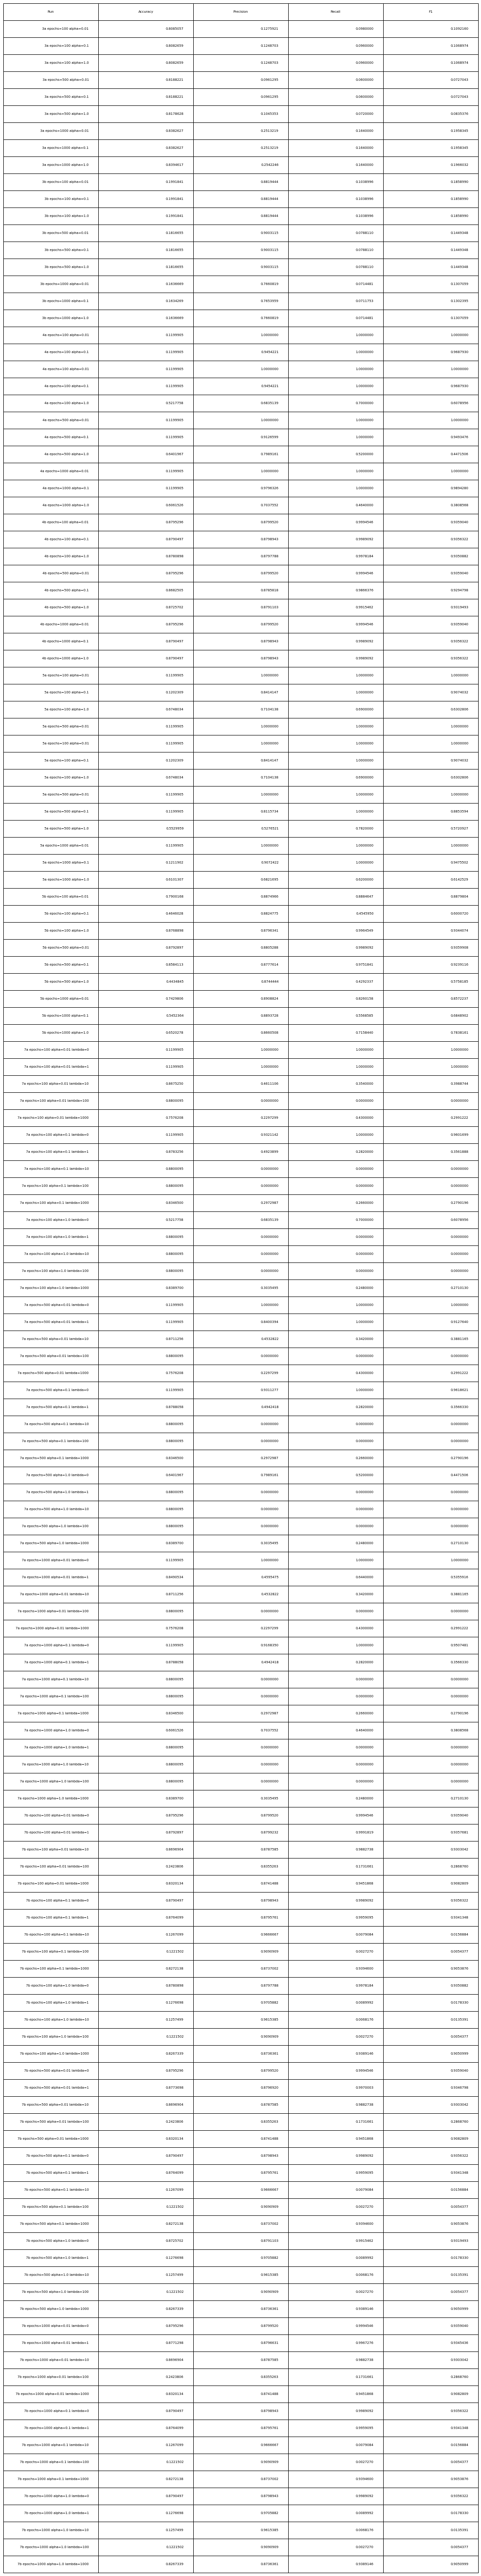

In [46]:
rows = ["{}|||{:.7f}|||{:.7f}|||{:.7f}|||{:.7f}".format(*res).split('|||') for res in results]
fig, axs = plt.subplots(1, 1)
axs.axis('off')
axs.axis('tight')

table = axs.table(cellText=rows, colLabels=['Run', 'Accuracy', 'Precision', 'Recall', 'F1'], loc='center')
table.set_fontsize(30)
table.scale(3, 3)
plt.show()


